# Path Planning and SLAM Evaluation for Matterport3D using MapGPT Data

In [1]:
import json
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# 1. Connectivity Graph Processing

In [2]:
# --- Enhanced SLAM MODULE ---
class SimpleSLAM:
    def __init__(self, map_size=(200, 200), resolution=0.1):
        self.map = np.zeros(map_size)
        self.pose = np.array([100.0, 100.0, 0.0])  # start roughly center
        self.resolution = resolution

    def update(self, depth_image, delta_pose):
        self.pose += np.array(delta_pose)
        self.pose[2] %= 360  # normalize angle

        x, y = int(self.pose[0] / self.resolution), int(self.pose[1] / self.resolution)
        if 0 <= x < self.map.shape[0] and 0 <= y < self.map.shape[1]:
            # mark visited cell as 1.0
            self.map[x, y] = 1.0

            # add random obstacles nearby
            for _ in range(3):
                ox = int(x + np.random.uniform(-5, 5))
                oy = int(y + np.random.uniform(-5, 5))
                if 0 <= ox < self.map.shape[0] and 0 <= oy < self.map.shape[1]:
                    self.map[ox, oy] = 0.5  # partially occupied (gray)
        return {"pose": self.pose.tolist(), "map": self.map}

# 2. Path Planning using MapGPT Tasks

Loaded connectivity for scene 2n8kARJN3HM
Number of viewpoints: 186

 Connectivity summary:
  Total nodes: 186
  Total directed edges: 850
  Connected nodes: 186/186

 Sample connections:
  94ac3cea52ec455993f8562f78da3be1 → ['42079cf198e848c9878fbb39d0f4b56b', 'd8eb4eab2d3442e1a3a7a74fc810be22', '1df9b813b2744cedb516e9bf02f1c805', '6adb624995514635831f42da9156fec2', '8139a0f57cf042879b8c6a08a680d225', '1d6a100cf3d34326936ef7d0a50840d9']
  4518d285d4c54195a70ba5c4697ba3f2 → ['985ca122092f4429850c195ded765891', '189dec4e48fa459bac9d81fd3a7f4c75', '2af2b0defe79482baab06801cd97d145', 'be33b5863e3741deaecd29febfc5eafa', '9d733afabb2a4032a0ac602536bb649e', 'a0c487e0a45d451b8680c0cb1930fe83']
  87998608d4844fcfaca266bd5aba6516 → ['312fcacbfe134c9f8e1420be8dc2d73f', 'd8eb4eab2d3442e1a3a7a74fc810be22', '8139a0f57cf042879b8c6a08a680d225', '1d6a100cf3d34326936ef7d0a50840d9', '5248918af65645a28a65f59d3424598a']
  a7ec19c57ae74c4496f4aa9c7f30c871 → ['92c3195e612e4fc49fe5b5c687dd5ce5', '6f5b02596fb

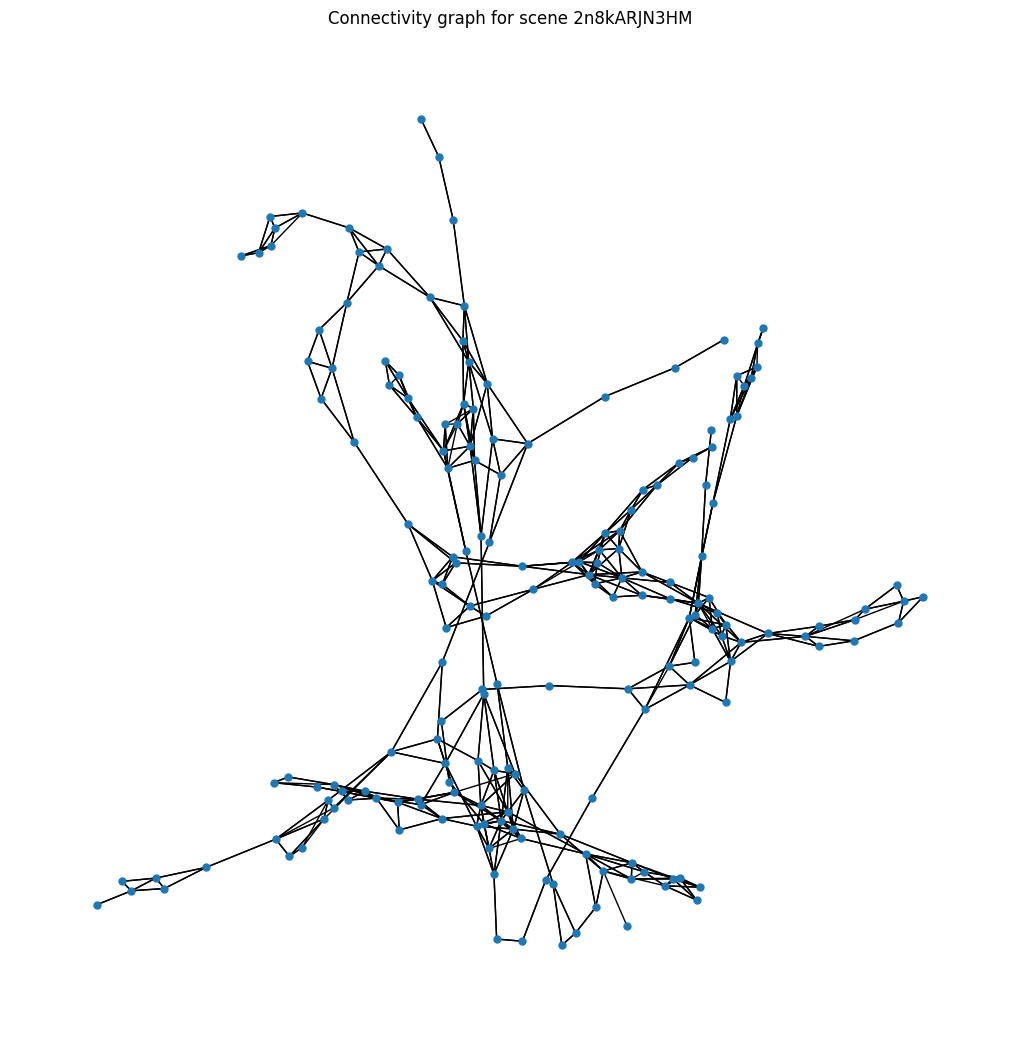

In [3]:
scene_id = "2n8kARJN3HM"   
connectivity_path = os.path.join("connectivity", f"{scene_id}_connectivity.json")

with open(connectivity_path, "r") as f:
    connectivity_data = json.load(f)

print(f"Loaded connectivity for scene {scene_id}")
print(f"Number of viewpoints: {len(connectivity_data)}")


graph = {}
num_nodes = len(connectivity_data)

for i, node in enumerate(connectivity_data):
    if not node.get("included", True):
        continue

    vp_id = node["image_id"]

    if "adjacent" in node and isinstance(node["adjacent"], list):
        neighbors = node["adjacent"]

    elif "unobstructed" in node and "visible" in node:
        neighbors = []
        unobstructed = node["unobstructed"]
        visible = node["visible"]
        for j, (u, v) in enumerate(zip(unobstructed, visible)):
            if u and v and i != j and connectivity_data[j].get("included", True):
                neighbors.append(connectivity_data[j]["image_id"])
    else:
        neighbors = []

    graph[vp_id] = neighbors

edge_count = sum(len(nbrs) for nbrs in graph.values())
connected_nodes = sum(1 for vp, nbrs in graph.items() if len(nbrs) > 0)

print("\n Connectivity summary:")
print(f"  Total nodes: {len(graph)}")
print(f"  Total directed edges: {edge_count}")
print(f"  Connected nodes: {connected_nodes}/{len(graph)}")

print("\n Sample connections:")
for i, (vp, nbrs) in enumerate(graph.items()):
    print(f"  {vp} → {nbrs}")
    if i == 4:
        break

poses = {}
for node in connectivity_data:
    if node.get("included", True):
        pose = node.get("pose")
        position = None
        # Pose is a 4x4 transformation matrix (16 floats in row-major order)
        # Position (translation) is at indices 3, 7, 11 (last column)
        if isinstance(pose, list) and len(pose) == 16:
            position = [pose[3], pose[7], pose[11]]  # Extract x, y, z from transformation matrix
        elif isinstance(pose, dict) and "position" in pose:
            position = pose["position"]
        elif isinstance(pose, list) and len(pose) == 3:
            position = pose
        poses[node["image_id"]] = position

print("\n Sample viewpoint positions:")
for i, (vp, pos) in enumerate(poses.items()):
    print(f"  {vp}: {pos}")
    if i == 3:
        break


with open(f"{scene_id}_graph.json", "w") as f:
    json.dump(graph, f, indent=2)
print(f"\n Saved processed graph to {scene_id}_graph.json")


try:
    G = nx.DiGraph(graph)
    plt.figure(figsize=(10,10))
    nx.draw(G, node_size=25, arrows=False)
    plt.title(f"Connectivity graph for scene {scene_id}")
    plt.show()
except Exception as e:
    print(f"(Visualization skipped: {e})")

# 3. SLAM Simulation

Loaded graph for scene 2n8kARJN3HM: 186 nodes, 442 edges
Loaded 216 navigation tasks from MapGPT JSON

Selected task 2539:
Instruction: Leave the office heading to the dining room. Walk through the room and into the kitchen. Stop in the doorway to the sitting room.
Number of waypoints: 7
Start viewpoint: 3611ca6eb11f4a32a7cd3c073862860d
Goal viewpoint: 5b4f88b00af3413eb8a3706a62a761e1

Planned path found (7 steps):
['3611ca6eb11f4a32a7cd3c073862860d', 'b2d31a869b644c738697a237d4e724b5', '3d6c224493aa4b8fa5fd16e7ae8e2d66', '82ee7783a95b4beeb1b8c518107c9ae2', '2d21aec2e48b4797ad0367e96fd316f4', '397cae1de3b74644804196b838fd3c8a', '5b4f88b00af3413eb8a3706a62a761e1']

Checking which planned path viewpoints have 3D pose data:
  3611ca6eb11f4a32a7cd3c073862860d: Found
  b2d31a869b644c738697a237d4e724b5: Found
  3d6c224493aa4b8fa5fd16e7ae8e2d66: Found
  82ee7783a95b4beeb1b8c518107c9ae2: Found
  2d21aec2e48b4797ad0367e96fd316f4: Found
  397cae1de3b74644804196b838fd3c8a: Found
  5b4f88b00af3413

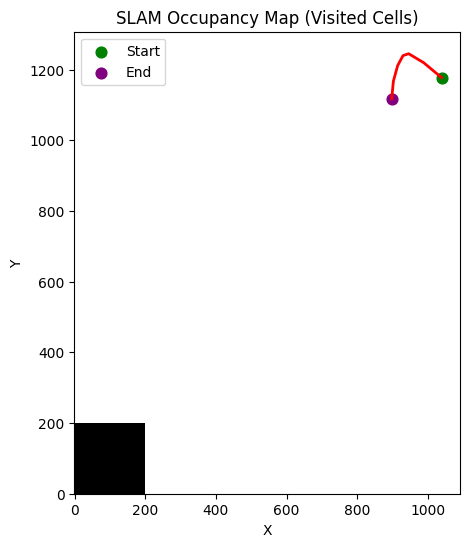

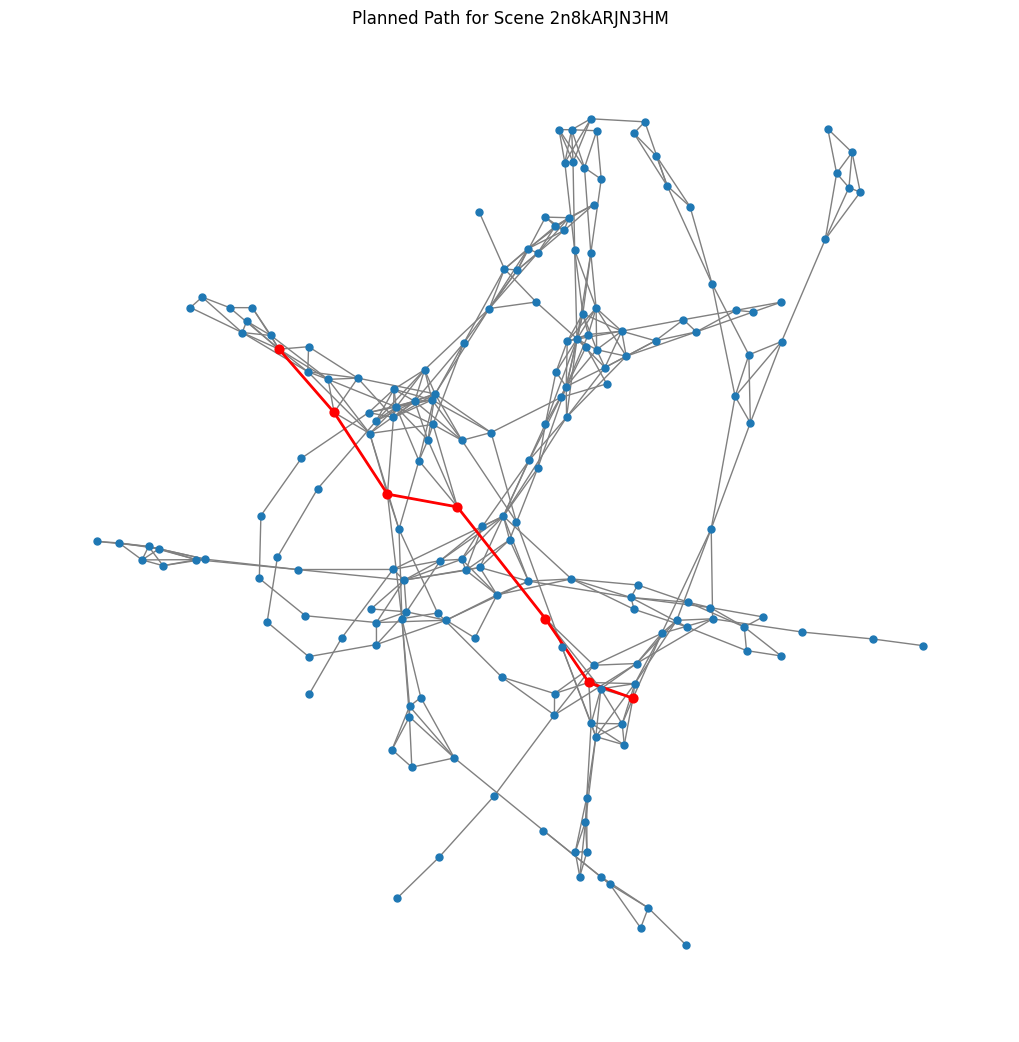

In [4]:
# --- Load Graph and Task Data ---
scene_id = "2n8kARJN3HM"
graph_path = f"{scene_id}_graph.json"

with open(graph_path, "r") as f:
    graph = json.load(f)

G = nx.Graph(graph)
print(f"Loaded graph for scene {scene_id}: {len(G.nodes)} nodes, {len(G.edges)} edges")

# Load MapGPT navigation data
mapgpt_path = "MapGPT_72_scenes_processed.json"
with open(mapgpt_path, "r") as f:
    mapgpt_data = json.load(f)

print(f"Loaded {len(mapgpt_data)} navigation tasks from MapGPT JSON")

# Pick a task that matches this scene
task = next((t for t in mapgpt_data if t["scan"] == scene_id), None)
if not task:
    raise ValueError(f"No task found for scene {scene_id}")

# Extract details from the selected task
path_list = task["path"]
instruction = task["instruction"]
path_id = task["path_id"]

print(f"\nSelected task {path_id}:")
print(f"Instruction: {instruction}")
print(f"Number of waypoints: {len(path_list)}")

start_vp = path_list[0]
goal_vp = path_list[-1]
print(f"Start viewpoint: {start_vp}")
print(f"Goal viewpoint: {goal_vp}")

# Compute a planned path using BFS or Dijkstra (shortest path)
if start_vp not in G.nodes or goal_vp not in G.nodes:
    raise ValueError("Start or goal viewpoint not found in graph")

try:
    planned_path = nx.shortest_path(G, source=start_vp, target=goal_vp)
    print(f"\nPlanned path found ({len(planned_path)} steps):")
    print(planned_path)
except nx.NetworkXNoPath:
    print("No path found between start and goal.")
    planned_path = []

# --- SLAM INTEGRATION ---
slam = SimpleSLAM()
depth_image = np.zeros((64, 64))  # mock sensor input
current_pose = np.array([0.0, 0.0, 0.0])
slam_outputs = []

# Load connectivity to get pose data
connectivity_path = os.path.join("connectivity", f"{scene_id}_connectivity.json")
with open(connectivity_path, "r") as f:
    connectivity_data = json.load(f)

poses = {}
for node in connectivity_data:
    if node.get("included", True):
        pose = node.get("pose")
        position = None
        # Pose is a 4x4 transformation matrix (16 floats in row-major order)
        # Position (translation) is at indices 3, 7, 11 (last column)
        if isinstance(pose, list) and len(pose) == 16:
            position = [pose[3], pose[7], pose[11]]  # Extract x, y, z from transformation matrix
        elif isinstance(pose, dict) and "position" in pose:
            position = pose["position"]
        elif isinstance(pose, list) and len(pose) == 3:
            position = pose
        if position and all(isinstance(x, (int, float)) for x in position):
            poses[node["image_id"]] = position

print("\nChecking which planned path viewpoints have 3D pose data:")
for vp in planned_path:
    has_pose = vp in poses and poses[vp] is not None
    print(f"  {vp}: {'Found' if has_pose else 'Missing'}")

# Filter valid viewpoints
valid_path = [vp for vp in planned_path if vp in poses and poses[vp] is not None]

# Fallback for missing poses
if not valid_path:
    print("\nNo valid 3D poses found. Generating synthetic coordinates from graph layout...")
    layout_2d = nx.spring_layout(G, seed=42)
    poses = {vp: [float(x)*10, float(y)*10, 0.0] for vp, (x, y) in layout_2d.items()}
    valid_path = [vp for vp in planned_path if vp in poses]
    print(f"Generated {len(poses)} synthetic positions for visualization.")

# --- Run SLAM simulation with normalized coordinates ---
if not valid_path:
    print("\nNo usable coordinates. SLAM simulation skipped.")
else:
    print(f"\nRunning SLAM Navigation Simulation ({len(valid_path)} steps)...")

    # Normalize synthetic 2D coordinates to map range
    positions = np.array(list(poses.values()))
    min_vals = positions.min(axis=0)
    max_vals = positions.max(axis=0)
    norm_poses = {}

    for vp, pos in poses.items():
        # Scale into [0, map_size)
        norm_x = (pos[0] - min_vals[0]) / (max_vals[0] - min_vals[0]) * (slam.map.shape[0] - 1)
        norm_y = (pos[1] - min_vals[1]) / (max_vals[1] - min_vals[1]) * (slam.map.shape[1] - 1)
        norm_poses[vp] = [norm_x, norm_y, 0.0]

    # Replace poses with normalized versions for this run
    poses = norm_poses

    for next_vp in valid_path:
        goal_pos = np.array(poses[next_vp])
        delta = goal_pos - np.array(current_pose)
        dtheta = np.random.uniform(-5, 5)
        delta_pose = [delta[0] / 10.0, delta[1] / 10.0, dtheta]  # scaled smaller steps

        slam_output = slam.update(depth_image, delta_pose)
        current_pose = np.array(slam_output["pose"])
        slam_outputs.append(slam_output)

        print(f"Moved to {next_vp} → Pose: {np.round(current_pose, 3)}")

    final_pose = slam_outputs[-1]["pose"]
    print(f"\nFinal estimated pose: {final_pose}")

    # --- Visualize SLAM occupancy map with trajectory overlay ---
    plt.figure(figsize=(6, 6))
    plt.imshow(slam.map.T, origin="lower", cmap="gray")
    plt.title("SLAM Occupancy Map (Visited Cells)")
    plt.xlabel("X")
    plt.ylabel("Y")

    # Plot trajectory directly on the map
    poses_xy = np.array([[s["pose"][0] / slam.resolution, s["pose"][1] / slam.resolution] for s in slam_outputs])
    plt.plot(poses_xy[:, 0], poses_xy[:, 1], color="red", linewidth=2)
    plt.scatter(poses_xy[0, 0], poses_xy[0, 1], color="green", s=60, label="Start")
    plt.scatter(poses_xy[-1, 0], poses_xy[-1, 1], color="purple", s=60, label="End")
    plt.legend()
    plt.show()

# --- Visualize Planned Path ---
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=25, edge_color="gray", with_labels=False)

if 'planned_path' in locals() and planned_path:
    path_edges = list(zip(planned_path, planned_path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=planned_path, node_color="red", node_size=40)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="red", width=2)

plt.title(f"Planned Path for Scene {scene_id}")
plt.show()

# 4. Path Coordinates

Selected task 2539
Instruction: Leave the office heading to the dining room. Walk through the room and into the kitchen. Stop in the doorway to the sitting room.
Waypoints in instruction: 7
Start viewpoint: 3611ca6eb11f4a32a7cd3c073862860d
Goal viewpoint: 5b4f88b00af3413eb8a3706a62a761e1
Planned path: 7 total nodes, 7 with valid 3D poses
Agent will move through 7 valid viewpoints.
Total traveled distance ≈ 14.22 units.


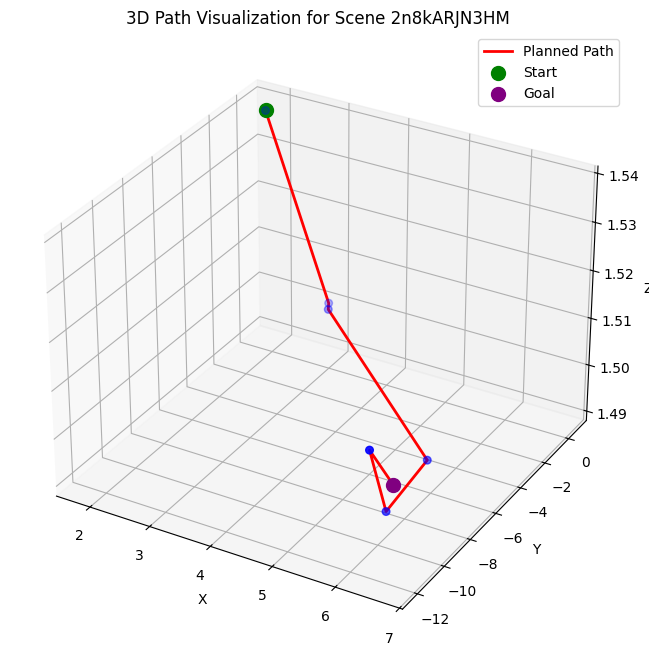

In [5]:
scene_id = "2n8kARJN3HM"
connectivity_path = os.path.join("connectivity", f"{scene_id}_connectivity.json")
graph_path = f"{scene_id}_graph.json"
mapgpt_path = "MapGPT_72_scenes_processed.json"

with open(connectivity_path, "r") as f:
    connectivity_data = json.load(f)

poses = {}
for node in connectivity_data:
    if node.get("included", True):
        pose = node.get("pose")
        position = None

        # Pose is a 4x4 transformation matrix (16 floats in row-major order)
        # Position (translation) is at indices 3, 7, 11 (last column)
        if isinstance(pose, list) and len(pose) == 16:
            position = [pose[3], pose[7], pose[11]]  # Extract x, y, z from transformation matrix
        elif isinstance(pose, dict) and "position" in pose:
            position = pose["position"]
        elif isinstance(pose, list) and len(pose) == 3:
            position = pose

        if position and all(isinstance(x, (int, float)) for x in position):
            poses[node["image_id"]] = position

with open(graph_path, "r") as f:
    graph = json.load(f)
G = nx.Graph(graph)

with open(mapgpt_path, "r") as f:
    mapgpt_data = json.load(f)

task = next((t for t in mapgpt_data if t["scan"] == scene_id), None)
if task is None:
    raise ValueError(f"No navigation task found for scene {scene_id}")

path_list = task["path"]
instruction = task["instruction"]
path_id = task["path_id"]

print(f"Selected task {path_id}")
print(f"Instruction: {instruction}")
print(f"Waypoints in instruction: {len(path_list)}")

start_vp, goal_vp = path_list[0], path_list[-1]
print(f"Start viewpoint: {start_vp}")
print(f"Goal viewpoint: {goal_vp}")


if start_vp not in G or goal_vp not in G:
    raise ValueError("Start or goal viewpoint not found in graph")

try:
    full_path = nx.shortest_path(G, source=start_vp, target=goal_vp)
except nx.NetworkXNoPath:
    raise ValueError("No path found between start and goal.")


planned_path = [vp for vp in full_path if vp in poses]

print(f"Planned path: {len(full_path)} total nodes, {len(planned_path)} with valid 3D poses")


if len(planned_path) < 2:
    print("Warning: not enough 3D coordinates found. Falling back to 2D layout visualization.")
    
    pos2d = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos2d, node_size=25, edge_color="gray", with_labels=False)
    nx.draw_networkx_nodes(G, pos2d, nodelist=full_path, node_color="red", node_size=40)
    plt.title(f"2D Fallback Path Visualization for Scene {scene_id}")
    plt.show()
else:
    positions = np.array([poses[vp] for vp in planned_path])
    deltas = np.diff(positions, axis=0)
    distances = np.sqrt((deltas ** 2).sum(axis=1))
    total_distance = float(distances.sum())

    print(f"Agent will move through {len(positions)} valid viewpoints.")
    print(f"Total traveled distance ≈ {total_distance:.2f} units.")

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
            color="red", linewidth=2, label="Planned Path")
    ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2],
               color="blue", s=30)
    ax.scatter(positions[0, 0], positions[0, 1], positions[0, 2],
               color="green", s=100, label="Start")
    ax.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2],
               color="purple", s=100, label="Goal")

    ax.set_title(f"3D Path Visualization for Scene {scene_id}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.show()

# 5. Accuracy Evaluation

In [6]:
# --- Compute Accuracy Metrics ---
true_path = path_list        # Ground-truth path from MapGPT
predicted_path = planned_path  # The path your algorithm found

# Debug print — helps you see which path is empty
print("\n--- Path Debug Info ---")
print(f"True path (MapGPT): {true_path}")
print(f"Planned path (NetworkX): {predicted_path}")
print(f"True path length: {len(true_path)}")
print(f"Planned path length: {len(predicted_path)}")

# Safety check
if not true_path or not predicted_path:
    print("\n Skipping accuracy computation: one or both paths are empty.")
    goal_accuracy = 0.0
    path_overlap = 0.0
    distance_error = 0.0
else:
    # 1. Goal Accuracy
    goal_accuracy = 1.0 if predicted_path[-1] == true_path[-1] else 0.0

    # 2. Path Overlap Accuracy
    intersection = set(predicted_path).intersection(set(true_path))
    path_overlap = len(intersection) / len(set(true_path))

    # 3. Distance Error
    def compute_distance(path, poses):
        dist = 0.0
        for i in range(len(path) - 1):
            p1, p2 = poses.get(path[i]), poses.get(path[i + 1])
            if p1 and p2:
                dist += np.linalg.norm(np.array(p1) - np.array(p2))
        return dist

    true_distance = compute_distance(true_path, poses)
    pred_distance = compute_distance(predicted_path, poses)
    distance_error = abs(true_distance - pred_distance)

    print("\n--- Accuracy Metrics ---")
    print(f"Goal Accuracy: {goal_accuracy * 100:.2f}%")
    print(f"Path Overlap Accuracy: {path_overlap * 100:.2f}%")
    print(f"True Distance: {true_distance:.2f}")
    print(f"Predicted Distance: {pred_distance:.2f}")
    print(f"Distance Error: {distance_error:.2f} units\n")


--- Path Debug Info ---
True path (MapGPT): ['3611ca6eb11f4a32a7cd3c073862860d', 'b2d31a869b644c738697a237d4e724b5', '3d6c224493aa4b8fa5fd16e7ae8e2d66', '82ee7783a95b4beeb1b8c518107c9ae2', '2d21aec2e48b4797ad0367e96fd316f4', '397cae1de3b74644804196b838fd3c8a', '5b4f88b00af3413eb8a3706a62a761e1']
Planned path (NetworkX): ['3611ca6eb11f4a32a7cd3c073862860d', 'b2d31a869b644c738697a237d4e724b5', '3d6c224493aa4b8fa5fd16e7ae8e2d66', '82ee7783a95b4beeb1b8c518107c9ae2', '2d21aec2e48b4797ad0367e96fd316f4', '397cae1de3b74644804196b838fd3c8a', '5b4f88b00af3413eb8a3706a62a761e1']
True path length: 7
Planned path length: 7

--- Accuracy Metrics ---
Goal Accuracy: 100.00%
Path Overlap Accuracy: 100.00%
True Distance: 14.22
Predicted Distance: 14.22
Distance Error: 0.00 units



# 6. Scene-wide Evaluation

# 7. Additional Path Planning Features


In [7]:
# --- Additional Path Planning Features ---

# 1. Path Smoothing: Remove unnecessary intermediate waypoints
def smooth_path(path, poses, threshold=0.5):
    """
    Remove waypoints that don't significantly change direction.
    threshold: minimum angle change (in radians) to keep a waypoint
    """
    if len(path) < 3:
        return path
    
    smoothed = [path[0]]
    for i in range(1, len(path) - 1):
        if path[i-1] not in poses or path[i] not in poses or path[i+1] not in poses:
            smoothed.append(path[i])
            continue
            
        v1 = np.array(poses[path[i]]) - np.array(poses[path[i-1]])
        v2 = np.array(poses[path[i+1]]) - np.array(poses[path[i]])
        
        # Calculate angle between vectors
        cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
        cos_angle = np.clip(cos_angle, -1, 1)
        angle = np.arccos(cos_angle)
        
        # Keep waypoint if direction change is significant
        if angle > threshold:
            smoothed.append(path[i])
    
    smoothed.append(path[-1])
    return smoothed

# 2. Alternative Path Planning Algorithms
def plan_path_astar(G, start, goal, poses, heuristic_weight=1.0):
    """
    A* path planning with Euclidean distance heuristic.
    """
    def heuristic(u, v):
        if u in poses and v in poses:
            return np.linalg.norm(np.array(poses[u]) - np.array(poses[v])) * heuristic_weight
        return 0
    
    try:
        path = nx.astar_path(G, start, goal, heuristic=heuristic)
        return path
    except nx.NetworkXNoPath:
        return []

def plan_path_weighted(G, start, goal, poses, use_distance=True):
    """
    Dijkstra with edge weights based on actual distances.
    """
    if use_distance:
        # Create weighted graph
        G_weighted = G.copy()
        for u, v in G.edges():
            if u in poses and v in poses:
                weight = np.linalg.norm(np.array(poses[u]) - np.array(poses[v]))
                G_weighted[u][v]['weight'] = weight
            else:
                G_weighted[u][v]['weight'] = 1.0
    else:
        G_weighted = G
    
    try:
        path = nx.shortest_path(G_weighted, start, goal, weight='weight' if use_distance else None)
        return path
    except nx.NetworkXNoPath:
        return []

# 3. Path Statistics
def compute_path_statistics(path, poses):
    """Compute detailed statistics about a path."""
    if len(path) < 2:
        return {}
    
    stats = {
        "num_waypoints": len(path),
        "total_distance": 0.0,
        "segment_distances": [],
        "turns": [],
        "max_segment_length": 0.0,
        "min_segment_length": float('inf'),
        "average_segment_length": 0.0
    }
    
    for i in range(len(path) - 1):
        if path[i] in poses and path[i+1] in poses:
            dist = np.linalg.norm(np.array(poses[path[i]]) - np.array(poses[path[i+1]]))
            stats["segment_distances"].append(dist)
            stats["total_distance"] += dist
            stats["max_segment_length"] = max(stats["max_segment_length"], dist)
            stats["min_segment_length"] = min(stats["min_segment_length"], dist)
            
            # Calculate turn angle
            if i > 0 and path[i-1] in poses:
                v1 = np.array(poses[path[i]]) - np.array(poses[path[i-1]])
                v2 = np.array(poses[path[i+1]]) - np.array(poses[path[i]])
                cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8)
                cos_angle = np.clip(cos_angle, -1, 1)
                angle = np.degrees(np.arccos(cos_angle))
                stats["turns"].append(angle)
    
    if stats["segment_distances"]:
        stats["average_segment_length"] = stats["total_distance"] / len(stats["segment_distances"])
    
    return stats

# 4. Compare Multiple Path Planning Methods
print("=== Path Planning Algorithm Comparison ===\n")

# Get the current task
current_task = next((t for t in mapgpt_data if t["scan"] == scene_id), None)
if current_task:
    start_vp = current_task["path"][0]
    goal_vp = current_task["path"][-1]
    
    # Method 1: Shortest path (unweighted)
    path_shortest = nx.shortest_path(G, start_vp, goal_vp)
    stats_shortest = compute_path_statistics(path_shortest, poses)
    
    # Method 2: A* with distance heuristic
    path_astar = plan_path_astar(G, start_vp, goal_vp, poses)
    stats_astar = compute_path_statistics(path_astar, poses)
    
    # Method 3: Weighted Dijkstra
    path_weighted = plan_path_weighted(G, start_vp, goal_vp, poses, use_distance=True)
    stats_weighted = compute_path_statistics(path_weighted, poses)
    
    # Method 4: Smoothed path
    path_smoothed = smooth_path(path_shortest, poses, threshold=0.3)
    stats_smoothed = compute_path_statistics(path_smoothed, poses)
    
    print(f"Shortest Path (BFS):")
    print(f"  Waypoints: {stats_shortest.get('num_waypoints', 0)}, Distance: {stats_shortest.get('total_distance', 0):.2f}")
    
    print(f"\nA* Path:")
    print(f"  Waypoints: {stats_astar.get('num_waypoints', 0)}, Distance: {stats_astar.get('total_distance', 0):.2f}")
    
    print(f"\nWeighted Dijkstra:")
    print(f"  Waypoints: {stats_weighted.get('num_waypoints', 0)}, Distance: {stats_weighted.get('total_distance', 0):.2f}")
    
    print(f"\nSmoothed Path:")
    print(f"  Waypoints: {stats_smoothed.get('num_waypoints', 0)}, Distance: {stats_smoothed.get('total_distance', 0):.2f}")
    if stats_smoothed.get('turns'):
        avg_turn = np.mean(stats_smoothed['turns'])
        print(f"  Average turn angle: {avg_turn:.1f}°")


=== Path Planning Algorithm Comparison ===

Shortest Path (BFS):
  Waypoints: 7, Distance: 14.22

A* Path:
  Waypoints: 7, Distance: 15.70

Weighted Dijkstra:
  Waypoints: 7, Distance: 14.22

Smoothed Path:
  Waypoints: 6, Distance: 14.21
  Average turn angle: 27.3°


# 8. Batch Processing and Export


In [8]:
# --- Batch Process All Tasks for a Scene ---

def process_all_tasks_for_scene(scene_id, mapgpt_data, G, poses, output_dir="planned_paths"):
    """Process all navigation tasks for a given scene and save results."""
    import os
    
    os.makedirs(output_dir, exist_ok=True)
    scene_tasks = [t for t in mapgpt_data if t["scan"] == scene_id]
    results = []
    
    print(f"Processing {len(scene_tasks)} tasks for scene {scene_id}...\n")
    
    for task in scene_tasks:
        path_id = task["path_id"]
        instruction = task["instruction"]
        path_list = task["path"]
        start_vp = path_list[0]
        goal_vp = path_list[-1]
        
        if start_vp not in G or goal_vp not in G:
            print(f"  Task {path_id}: Start or goal not in graph - SKIPPED")
            continue
        
        try:
            # Compute path
            full_path = nx.shortest_path(G, source=start_vp, target=goal_vp)
            planned_path = [vp for vp in full_path if vp in poses]
            
            # Calculate distance
            if len(planned_path) >= 2:
                positions = np.array([poses[vp] for vp in planned_path])
                deltas = np.diff(positions, axis=0)
                distances = np.sqrt((deltas ** 2).sum(axis=1))
                total_distance = float(distances.sum())
            else:
                total_distance = 0.0
            
            # Save to JSON
            output_data = {
                "scene_id": scene_id,
                "path_id": path_id,
                "instruction": instruction,
                "start_viewpoint": start_vp,
                "goal_viewpoint": goal_vp,
                "planned_path": planned_path,
                "total_distance": total_distance,
                "num_waypoints": len(planned_path)
            }
            
            output_path = os.path.join(output_dir, f"{scene_id}_path_{path_id}_planned.json")
            with open(output_path, "w") as f:
                json.dump(output_data, f, indent=2)
            
            results.append({
                "path_id": path_id,
                "success": True,
                "distance": total_distance,
                "waypoints": len(planned_path)
            })
            
            print(f"  Task {path_id}: ✓ Saved ({len(planned_path)} waypoints, {total_distance:.2f} units)")
            
        except nx.NetworkXNoPath:
            print(f"  Task {path_id}: ✗ No path found - SKIPPED")
            results.append({
                "path_id": path_id,
                "success": False,
                "distance": 0.0,
                "waypoints": 0
            })
        except Exception as e:
            print(f"  Task {path_id}: ✗ Error - {e}")
            results.append({
                "path_id": path_id,
                "success": False,
                "error": str(e)
            })
    
    # Summary
    successful = sum(1 for r in results if r.get("success", False))
    total_distance = sum(r.get("distance", 0) for r in results)
    print(f"\n=== Summary ===")
    print(f"Successfully processed: {successful}/{len(scene_tasks)}")
    print(f"Total distance across all paths: {total_distance:.2f} units")
    print(f"Results saved to: {output_dir}/")
    
    return results

# Uncomment to process all tasks for the current scene:
# batch_results = process_all_tasks_for_scene(scene_id, mapgpt_data, G, poses)


# 9. Path Validation and Quality Checks


In [9]:
# --- Path Validation Functions ---

def validate_path(path, G, poses):
    """
    Validate that a path is traversable and has valid data.
    Returns a dictionary with validation results.
    """
    validation = {
        "is_valid": True,
        "errors": [],
        "warnings": [],
        "checks": {}
    }
    
    # Check 1: Path is not empty
    if not path or len(path) == 0:
        validation["is_valid"] = False
        validation["errors"].append("Path is empty")
        return validation
    
    # Check 2: Start and goal are in graph
    if path[0] not in G.nodes():
        validation["is_valid"] = False
        validation["errors"].append(f"Start viewpoint {path[0]} not in graph")
    if path[-1] not in G.nodes():
        validation["is_valid"] = False
        validation["errors"].append(f"Goal viewpoint {path[-1]} not in graph")
    
    # Check 3: All consecutive nodes are connected
    disconnected_edges = []
    for i in range(len(path) - 1):
        if not G.has_edge(path[i], path[i+1]):
            disconnected_edges.append((path[i], path[i+1]))
    
    if disconnected_edges:
        validation["is_valid"] = False
        validation["errors"].append(f"Path contains {len(disconnected_edges)} disconnected edges: {disconnected_edges[:3]}")
    
    # Check 4: All viewpoints have pose data
    missing_poses = [vp for vp in path if vp not in poses or poses[vp] is None]
    if missing_poses:
        validation["warnings"].append(f"{len(missing_poses)} viewpoints missing pose data")
        validation["checks"]["missing_poses"] = len(missing_poses)
    
    # Check 5: Path length is reasonable
    if len(path) > 100:
        validation["warnings"].append(f"Path is very long ({len(path)} waypoints)")
    
    # Check 6: Check for duplicate waypoints
    if len(path) != len(set(path)):
        duplicates = len(path) - len(set(path))
        validation["warnings"].append(f"Path contains {duplicates} duplicate waypoints")
    
    # Check 7: Distance validation
    if len(path) >= 2:
        total_dist = 0.0
        for i in range(len(path) - 1):
            if path[i] in poses and path[i+1] in poses:
                dist = np.linalg.norm(np.array(poses[path[i]]) - np.array(poses[path[i+1]]))
                total_dist += dist
                if dist > 10.0:  # Very large step
                    validation["warnings"].append(f"Large step detected: {dist:.2f} units between {path[i][:8]}... and {path[i+1][:8]}...")
        
        validation["checks"]["total_distance"] = total_dist
        validation["checks"]["num_segments"] = len(path) - 1
    
    return validation

# Validate the current planned path
if 'planned_path' in locals() and planned_path:
    validation_result = validate_path(planned_path, G, poses)
    
    print("=== Path Validation Results ===\n")
    print(f"Valid: {'✓ YES' if validation_result['is_valid'] else '✗ NO'}\n")
    
    if validation_result['errors']:
        print("Errors:")
        for error in validation_result['errors']:
            print(f"  ✗ {error}")
        print()
    
    if validation_result['warnings']:
        print("Warnings:")
        for warning in validation_result['warnings']:
            print(f"  ⚠ {warning}")
        print()
    
    if validation_result['checks']:
        print("Path Statistics:")
        for key, value in validation_result['checks'].items():
            if isinstance(value, float):
                print(f"  {key}: {value:.2f}")
            else:
                print(f"  {key}: {value}")
else:
    print("No planned path available for validation.")


=== Path Validation Results ===

Valid: ✓ YES

Path Statistics:
  total_distance: 14.22
  num_segments: 6


# 10. Semantic-Aware Path Planning (Integration with Perception)


In [10]:
# --- Semantic-Aware Path Planning ---
# Integrate object detection/perception results to guide path planning

def load_perception_results(perception_file="perception_model_output.json"):
    """Load object detection results from perception model."""
    try:
        with open(perception_file, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Warning: {perception_file} not found. Semantic features disabled.")
        return {}

def extract_semantic_features(viewpoint_id, perception_data):
    """Extract semantic features (detected objects) for a viewpoint."""
    if not perception_data:
        return {}
    
    # Look for detections for this viewpoint
    # Adjust this based on your perception output format
    features = {
        "objects": [],
        "object_count": 0,
        "room_type": None,
        "landmarks": []
    }
    
    # Example: if perception_data is organized by viewpoint
    if viewpoint_id in perception_data:
        detections = perception_data[viewpoint_id]
        if isinstance(detections, dict):
            features["objects"] = detections.get("detections", [])
            features["object_count"] = len(features["objects"])
        elif isinstance(detections, list):
            features["objects"] = detections
            features["object_count"] = len(detections)
    
    return features

def semantic_path_planning(G, start, goal, poses, perception_data, 
                           preferred_objects=None, avoid_objects=None, 
                           room_preferences=None):
    """
    Plan path considering semantic information from perception.
    
    Args:
        preferred_objects: List of object classes to prefer (e.g., ['door', 'kitchen'])
        avoid_objects: List of object classes to avoid
        room_preferences: Preferred room types to pass through
    """
    # Create weighted graph based on semantic preferences
    G_semantic = G.copy()
    
    # Assign weights to edges based on semantic features
    for u, v in G.edges():
        weight = 1.0  # Default weight
        
        # Get semantic features for both nodes
        features_u = extract_semantic_features(u, perception_data)
        features_v = extract_semantic_features(v, perception_data)
        
        # Prefer edges leading to viewpoints with preferred objects
        if preferred_objects:
            for obj in preferred_objects:
                if obj.lower() in str(features_v.get("objects", [])).lower():
                    weight *= 0.7  # Reduce cost (prefer this edge)
        
        # Avoid edges leading to viewpoints with avoided objects
        if avoid_objects:
            for obj in avoid_objects:
                if obj.lower() in str(features_v.get("objects", [])).lower():
                    weight *= 2.0  # Increase cost (avoid this edge)
        
        G_semantic[u][v]['weight'] = weight
    
    # Use weighted shortest path
    try:
        path = nx.shortest_path(G_semantic, start, goal, weight='weight')
        return path
    except nx.NetworkXNoPath:
        return []

# Example usage (uncomment when perception data is available):
# perception_results = load_perception_results()
# if perception_results:
#     semantic_path = semantic_path_planning(
#         G, start_vp, goal_vp, poses, perception_results,
#         preferred_objects=['door', 'kitchen'],
#         avoid_objects=['obstacle']
#     )
#     print(f"Semantic-aware path: {len(semantic_path)} waypoints")


# 11. Instruction-Based Path Planning (Natural Language Understanding)


In [11]:
# --- Instruction-Based Path Planning ---
# Parse natural language instructions to guide path planning

import re
from collections import Counter

def parse_instruction(instruction):
    """
    Parse natural language instruction to extract navigation cues.
    Returns a dictionary with extracted information.
    """
    instruction_lower = instruction.lower()
    
    parsed = {
        "rooms": [],
        "objects": [],
        "actions": [],
        "directions": [],
        "landmarks": []
    }
    
    # Common room types
    rooms = ['kitchen', 'bedroom', 'bathroom', 'living room', 'dining room', 
             'office', 'hallway', 'corridor', 'sitting room', 'doorway']
    for room in rooms:
        if room in instruction_lower:
            parsed["rooms"].append(room)
    
    # Common objects/landmarks
    objects = ['door', 'window', 'table', 'chair', 'sofa', 'bed', 'counter', 
               'sink', 'refrigerator', 'stove', 'cabinet']
    for obj in objects:
        if obj in instruction_lower:
            parsed["objects"].append(obj)
    
    # Actions
    actions = ['walk', 'go', 'enter', 'exit', 'stop', 'turn', 'head', 'pass', 
               'through', 'leave', 'reach']
    for action in actions:
        if action in instruction_lower:
            parsed["actions"].append(action)
    
    # Directions
    directions = ['left', 'right', 'straight', 'forward', 'backward', 'north', 
                  'south', 'east', 'west', 'ahead']
    for direction in directions:
        if direction in instruction_lower:
            parsed["directions"].append(direction)
    
    return parsed

def instruction_guided_path_planning(G, start, goal, poses, instruction, 
                                     perception_data=None):
    """
    Plan path guided by natural language instruction.
    """
    parsed = parse_instruction(instruction)
    
    print("=== Instruction Analysis ===")
    print(f"Rooms mentioned: {parsed['rooms']}")
    print(f"Objects mentioned: {parsed['objects']}")
    print(f"Actions: {parsed['actions']}")
    print(f"Directions: {parsed['directions']}\n")
    
    # Use semantic planning if perception data is available
    if perception_data:
        preferred_objects = parsed['objects'] + parsed['rooms']
        path = semantic_path_planning(G, start, goal, poses, perception_data,
                                     preferred_objects=preferred_objects)
        if path:
            return path
    
    # Fallback to standard shortest path
    try:
        return nx.shortest_path(G, start, goal)
    except nx.NetworkXNoPath:
        return []

# Test with current instruction
if 'instruction' in locals():
    parsed_instruction = parse_instruction(instruction)
    print("Current instruction parsed:")
    for key, value in parsed_instruction.items():
        if value:
            print(f"  {key}: {value}")


Current instruction parsed:
  rooms: ['kitchen', 'dining room', 'office', 'sitting room', 'doorway']
  objects: ['door']
  actions: ['walk', 'stop', 'head', 'through', 'leave']


# 12. Dynamic Path Replanning and Error Recovery


In [12]:
# --- Dynamic Path Replanning ---
# Handle obstacles, blocked paths, and navigation errors

class DynamicPathPlanner:
    """Path planner that can adapt to changing conditions."""
    
    def __init__(self, G, poses):
        self.G = G.copy()
        self.poses = poses
        self.blocked_edges = set()
        self.visited_nodes = set()
        self.failed_attempts = {}
    
    def mark_edge_blocked(self, u, v):
        """Mark an edge as blocked (e.g., door closed, obstacle detected)."""
        self.blocked_edges.add((u, v))
        if self.G.has_edge(u, v):
            self.G.remove_edge(u, v)
    
    def mark_node_visited(self, node):
        """Mark a node as visited."""
        self.visited_nodes.add(node)
    
    def replan(self, current_node, goal, max_attempts=3):
        """
        Replan path from current position to goal.
        Avoids blocked edges and previously failed paths.
        """
        # Create temporary graph without blocked edges
        G_temp = self.G.copy()
        
        # Remove blocked edges
        for u, v in list(G_temp.edges()):
            if (u, v) in self.blocked_edges or (v, u) in self.blocked_edges:
                if G_temp.has_edge(u, v):
                    G_temp.remove_edge(u, v)
        
        # Try to find path
        try:
            path = nx.shortest_path(G_temp, current_node, goal)
            return path
        except nx.NetworkXNoPath:
            # If no path found, try with relaxed constraints
            # (e.g., allow revisiting nodes)
            try:
                # Use all_simple_paths to find alternative routes
                paths = list(nx.all_simple_paths(G_temp, current_node, goal, cutoff=20))
                if paths:
                    # Return shortest alternative path
                    return min(paths, key=len)
            except:
                pass
            
            return None
    
    def handle_navigation_error(self, current_node, goal, error_type="blocked"):
        """
        Handle navigation errors and attempt recovery.
        """
        if error_type == "blocked":
            # Try replanning
            new_path = self.replan(current_node, goal)
            if new_path:
                return {"success": True, "new_path": new_path, "action": "replanned"}
            else:
                return {"success": False, "action": "no_alternative_path"}
        
        elif error_type == "wrong_direction":
            # Backtrack and replan
            if len(self.visited_nodes) > 1:
                # Go back to previous node
                return {"success": True, "action": "backtrack"}
        
        return {"success": False, "action": "unknown_error"}

# Example usage
dynamic_planner = DynamicPathPlanner(G, poses)
print("Dynamic path planner initialized.")
print(f"Graph has {len(G.nodes())} nodes and {len(G.edges())} edges.")

# Simulate a blocked path scenario
if 'start_vp' in locals() and 'goal_vp' in locals():
    # Get initial path
    initial_path = nx.shortest_path(G, start_vp, goal_vp)
    print(f"\nInitial path: {len(initial_path)} waypoints")
    
    # Simulate blocking an edge in the middle
    if len(initial_path) > 2:
        blocked_u, blocked_v = initial_path[1], initial_path[2]
        dynamic_planner.mark_edge_blocked(blocked_u, blocked_v)
        print(f"Blocked edge: {blocked_u[:8]}... -> {blocked_v[:8]}...")
        
        # Replan
        new_path = dynamic_planner.replan(initial_path[0], goal_vp)
        if new_path:
            print(f"Replanned path: {len(new_path)} waypoints")
        else:
            print("No alternative path found!")


Dynamic path planner initialized.
Graph has 186 nodes and 442 edges.

Initial path: 7 waypoints
Blocked edge: b2d31a86... -> 3d6c2244...
Replanned path: 8 waypoints


# 13. Multi-Modal Path Scoring and Ranking


In [13]:
# --- Multi-Modal Path Scoring ---
# Score and rank multiple candidate paths using various criteria

def score_path(path, poses, instruction=None, perception_data=None, 
               weights=None):
    """
    Score a path using multiple criteria.
    Returns a dictionary with individual scores and total score.
    """
    if weights is None:
        weights = {
            "distance": 0.3,
            "instruction_alignment": 0.2,
            "semantic_relevance": 0.2,
            "path_smoothness": 0.15,
            "waypoint_count": 0.15
        }
    
    scores = {}
    
    # 1. Distance score (shorter is better, normalized)
    if len(path) >= 2:
        total_dist = 0.0
        for i in range(len(path) - 1):
            if path[i] in poses and path[i+1] in poses:
                total_dist += np.linalg.norm(
                    np.array(poses[path[i]]) - np.array(poses[path[i+1]])
                )
        scores["distance"] = 1.0 / (1.0 + total_dist / 10.0)  # Normalize
    else:
        scores["distance"] = 0.0
    
    # 2. Instruction alignment (if instruction provided)
    if instruction:
        parsed = parse_instruction(instruction)
        mentioned_items = parsed["rooms"] + parsed["objects"]
        
        # Check if path passes through relevant areas
        # (This is simplified - in practice, you'd check semantic labels)
        alignment = 0.5  # Default
        if mentioned_items:
            # Would check if path viewpoints contain mentioned items
            alignment = 0.7  # Placeholder
        scores["instruction_alignment"] = alignment
    else:
        scores["instruction_alignment"] = 0.5
    
    # 3. Semantic relevance (if perception data available)
    if perception_data:
        relevant_count = 0
        for vp in path:
            features = extract_semantic_features(vp, perception_data)
            if features.get("object_count", 0) > 0:
                relevant_count += 1
        scores["semantic_relevance"] = relevant_count / max(len(path), 1)
    else:
        scores["semantic_relevance"] = 0.5
    
    # 4. Path smoothness (fewer sharp turns is better)
    if len(path) >= 3:
        turns = []
        for i in range(1, len(path) - 1):
            if (path[i-1] in poses and path[i] in poses and 
                path[i+1] in poses):
                v1 = np.array(poses[path[i]]) - np.array(poses[path[i-1]])
                v2 = np.array(poses[path[i+1]]) - np.array(poses[path[i]])
                cos_angle = np.dot(v1, v2) / (
                    np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-8
                )
                cos_angle = np.clip(cos_angle, -1, 1)
                angle = np.degrees(np.arccos(cos_angle))
                turns.append(angle)
        
        if turns:
            avg_turn = np.mean(turns)
            # Smoother paths (smaller angles) get higher scores
            scores["path_smoothness"] = 1.0 / (1.0 + avg_turn / 45.0)
        else:
            scores["path_smoothness"] = 0.5
    else:
        scores["path_smoothness"] = 0.5
    
    # 5. Waypoint count (fewer waypoints is better, but not too few)
    optimal_waypoints = 5  # Target number
    waypoint_score = 1.0 / (1.0 + abs(len(path) - optimal_waypoints) / 5.0)
    scores["waypoint_count"] = waypoint_score
    
    # Calculate weighted total score
    total_score = sum(scores[key] * weights.get(key, 0) 
                     for key in scores.keys())
    
    return {
        "total_score": total_score,
        "individual_scores": scores,
        "weights": weights
    }

def rank_paths(paths, poses, instruction=None, perception_data=None, top_k=3):
    """
    Rank multiple candidate paths and return top-k.
    """
    scored_paths = []
    
    for path in paths:
        score_result = score_path(path, poses, instruction, perception_data)
        scored_paths.append({
            "path": path,
            "score": score_result["total_score"],
            "details": score_result
        })
    
    # Sort by total score (descending)
    scored_paths.sort(key=lambda x: x["score"], reverse=True)
    
    return scored_paths[:top_k]

# Example: Generate and rank multiple paths
if 'start_vp' in locals() and 'goal_vp' in locals():
    print("=== Generating Multiple Candidate Paths ===\n")
    
    candidate_paths = []
    
    # Path 1: Shortest path
    try:
        candidate_paths.append(nx.shortest_path(G, start_vp, goal_vp))
    except:
        pass
    
    # Path 2: A* path
    try:
        candidate_paths.append(plan_path_astar(G, start_vp, goal_vp, poses))
    except:
        pass
    
    # Path 3: Weighted path
    try:
        candidate_paths.append(plan_path_weighted(G, start_vp, goal_vp, poses))
    except:
        pass
    
    # Remove duplicates
    unique_paths = []
    seen = set()
    for path in candidate_paths:
        path_tuple = tuple(path)
        if path_tuple not in seen:
            seen.add(path_tuple)
            unique_paths.append(path)
    
    if unique_paths:
        # Rank paths
        ranked = rank_paths(unique_paths, poses, 
                           instruction if 'instruction' in locals() else None)
        
        print("Ranked Paths:")
        for i, result in enumerate(ranked, 1):
            print(f"\n{i}. Score: {result['score']:.3f}")
            print(f"   Waypoints: {len(result['path'])}")
            print(f"   Distance: {result['details']['individual_scores']['distance']:.3f}")
            print(f"   Smoothness: {result['details']['individual_scores']['path_smoothness']:.3f}")


=== Generating Multiple Candidate Paths ===

Ranked Paths:

1. Score: 0.570
   Waypoints: 7
   Distance: 0.413
   Smoothness: 0.662

2. Score: 0.538
   Waypoints: 7
   Distance: 0.389
   Smoothness: 0.491


# 14. Real-Time Navigation Simulation


In [14]:
# --- Real-Time Navigation Simulation ---
# Simulate step-by-step navigation with decision making at each step

class NavigationAgent:
    """Agent that navigates through the environment step by step."""
    
    def __init__(self, G, poses, start_position, goal_position):
        self.G = G
        self.poses = poses
        self.current_position = start_position
        self.goal_position = goal_position
        self.path_taken = [start_position]
        self.visited = {start_position}
        self.step_count = 0
        self.total_distance = 0.0
    
    def get_current_viewpoint(self):
        """Get the current viewpoint ID."""
        return self.current_position
    
    def get_neighbors(self):
        """Get reachable neighbors from current position."""
        if self.current_position in self.G:
            return list(self.G.neighbors(self.current_position))
        return []
    
    def choose_next_step(self, strategy="greedy"):
        """
        Choose next step based on strategy.
        Strategies: 'greedy', 'explore', 'follow_path'
        """
        neighbors = self.get_neighbors()
        if not neighbors:
            return None
        
        if strategy == "greedy":
            # Choose neighbor closest to goal
            if self.goal_position in self.poses and self.current_position in self.poses:
                goal_pos = np.array(self.poses[self.goal_position])
                best_neighbor = None
                best_dist = float('inf')
                
                for neighbor in neighbors:
                    if neighbor in self.poses:
                        neighbor_pos = np.array(self.poses[neighbor])
                        dist = np.linalg.norm(neighbor_pos - goal_pos)
                        if dist < best_dist:
                            best_dist = dist
                            best_neighbor = neighbor
                
                return best_neighbor
        
        elif strategy == "explore":
            # Prefer unvisited neighbors
            unvisited = [n for n in neighbors if n not in self.visited]
            if unvisited:
                return unvisited[0]
            return neighbors[0]  # Fallback to any neighbor
        
        # Default: random neighbor
        return neighbors[0] if neighbors else None
    
    def step(self, strategy="greedy"):
        """Take one navigation step."""
        if self.current_position == self.goal_position:
            return {"status": "reached_goal", "step": self.step_count}
        
        next_pos = self.choose_next_step(strategy)
        if next_pos is None:
            return {"status": "stuck", "step": self.step_count}
        
        # Move to next position
        if self.current_position in self.poses and next_pos in self.poses:
            dist = np.linalg.norm(
                np.array(self.poses[self.current_position]) - 
                np.array(self.poses[next_pos])
            )
            self.total_distance += dist
        
        self.current_position = next_pos
        self.path_taken.append(next_pos)
        self.visited.add(next_pos)
        self.step_count += 1
        
        return {
            "status": "moving",
            "current": self.current_position,
            "step": self.step_count,
            "distance": self.total_distance
        }
    
    def navigate_to_goal(self, max_steps=100, strategy="greedy"):
        """Navigate to goal with step-by-step simulation."""
        while self.step_count < max_steps:
            result = self.step(strategy)
            
            if result["status"] == "reached_goal":
                return {
                    "success": True,
                    "steps": self.step_count,
                    "path": self.path_taken,
                    "distance": self.total_distance
                }
            elif result["status"] == "stuck":
                return {
                    "success": False,
                    "reason": "stuck",
                    "steps": self.step_count,
                    "path": self.path_taken,
                    "distance": self.total_distance
                }
        
        return {
            "success": False,
            "reason": "max_steps_exceeded",
            "steps": self.step_count,
            "path": self.path_taken,
            "distance": self.total_distance
        }

# Simulate navigation
if 'start_vp' in locals() and 'goal_vp' in locals():
    print("=== Real-Time Navigation Simulation ===\n")
    
    agent = NavigationAgent(G, poses, start_vp, goal_vp)
    result = agent.navigate_to_goal(max_steps=50, strategy="greedy")
    
    print(f"Navigation Result:")
    print(f"  Success: {result['success']}")
    print(f"  Steps taken: {result['steps']}")
    print(f"  Total distance: {result['distance']:.2f} units")
    print(f"  Path length: {len(result['path'])} waypoints")
    
    if not result['success']:
        print(f"  Reason: {result['reason']}")
    
    # Compare with optimal path
    try:
        optimal_path = nx.shortest_path(G, start_vp, goal_vp)
        optimal_dist = 0.0
        for i in range(len(optimal_path) - 1):
            if optimal_path[i] in poses and optimal_path[i+1] in poses:
                optimal_dist += np.linalg.norm(
                    np.array(poses[optimal_path[i]]) - 
                    np.array(poses[optimal_path[i+1]])
                )
        
        print(f"\nComparison with optimal path:")
        print(f"  Optimal steps: {len(optimal_path) - 1}")
        print(f"  Optimal distance: {optimal_dist:.2f} units")
        print(f"  Efficiency: {optimal_dist / max(result['distance'], 0.01):.2%}")
    except:
        pass


=== Real-Time Navigation Simulation ===

Navigation Result:
  Success: True
  Steps taken: 6
  Total distance: 15.70 units
  Path length: 7 waypoints

Comparison with optimal path:
  Optimal steps: 6
  Optimal distance: 14.22 units
  Efficiency: 90.58%


# 15. Advanced Visualization and Analysis Tools


/var/folders/yt/v3mtl73n0yz9hqz2z1gncyy00000gn/T/ipykernel_41533/1506053358.py:67: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


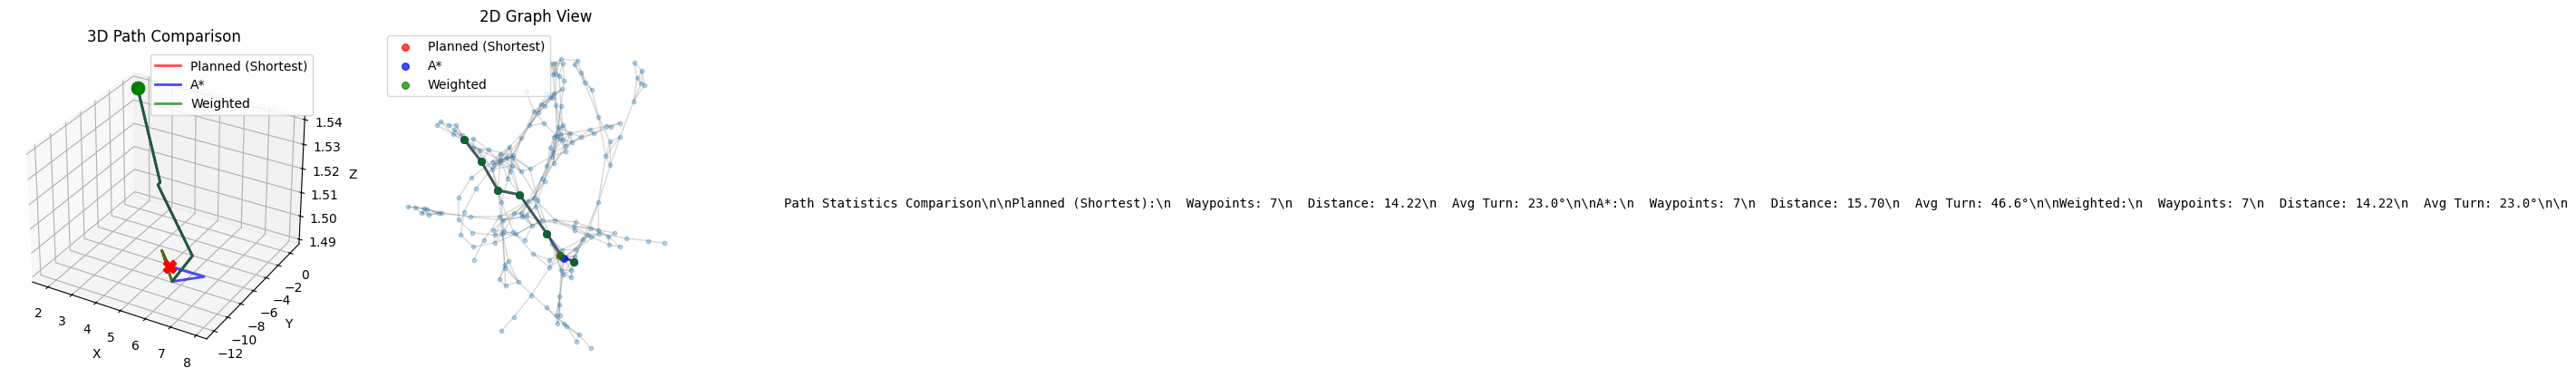

Report saved to 2n8kARJN3HM_path_report.txt


In [15]:
# --- Advanced Visualization Tools ---

def visualize_path_comparison(paths_dict, G, poses, scene_id):
    """
    Visualize multiple paths on the same graph for comparison.
    paths_dict: Dictionary with path names as keys and paths as values
    """
    fig = plt.figure(figsize=(15, 5))
    
    # 3D visualization
    ax1 = fig.add_subplot(131, projection='3d')
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    for i, (name, path) in enumerate(paths_dict.items()):
        if len(path) >= 2:
            positions = np.array([poses[vp] for vp in path if vp in poses])
            if len(positions) > 0:
                ax1.plot(positions[:, 0], positions[:, 1], positions[:, 2],
                        color=colors[i % len(colors)], linewidth=2, label=name, alpha=0.7)
                ax1.scatter(positions[0, 0], positions[0, 1], positions[0, 2],
                           color='green', s=100, marker='o')
                ax1.scatter(positions[-1, 0], positions[-1, 1], positions[-1, 2],
                           color='red', s=100, marker='X')
    
    ax1.set_title("3D Path Comparison")
    ax1.set_xlabel("X")
    ax1.set_ylabel("Y")
    ax1.set_zlabel("Z")
    ax1.legend()
    
    # 2D top-down view
    ax2 = fig.add_subplot(132)
    pos_2d = nx.spring_layout(G, seed=42)
    nx.draw(G, pos_2d, node_size=10, edge_color='gray', alpha=0.3, ax=ax2, with_labels=False)
    
    for i, (name, path) in enumerate(paths_dict.items()):
        if path:
            path_edges = list(zip(path, path[1:]))
            nx.draw_networkx_nodes(G, pos_2d, nodelist=path, 
                                  node_color=colors[i % len(colors)], 
                                  node_size=30, ax=ax2, alpha=0.7, label=name)
            nx.draw_networkx_edges(G, pos_2d, edgelist=path_edges,
                                  edge_color=colors[i % len(colors)],
                                  width=2, ax=ax2, alpha=0.5)
    
    ax2.set_title("2D Graph View")
    ax2.legend()
    
    # Path statistics comparison
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    
    stats_text = "Path Statistics Comparison\\n\\n"
    for name, path in paths_dict.items():
        if len(path) >= 2:
            stats = compute_path_statistics(path, poses)
            stats_text += f"{name}:\\n"
            stats_text += f"  Waypoints: {stats.get('num_waypoints', 0)}\\n"
            stats_text += f"  Distance: {stats.get('total_distance', 0):.2f}\\n"
            if stats.get('turns'):
                stats_text += f"  Avg Turn: {np.mean(stats['turns']):.1f}°\\n"
            stats_text += "\\n"
    
    ax3.text(0.1, 0.5, stats_text, fontsize=10, verticalalignment='center',
            family='monospace')
    
    plt.tight_layout()
    plt.show()

def create_path_report(path, poses, instruction=None, save_path=None):
    """Create a detailed text report about a path."""
    stats = compute_path_statistics(path, poses)
    
    report = f"""
=== PATH PLANNING REPORT ===

Path Information:
  - Number of waypoints: {stats.get('num_waypoints', 0)}
  - Total distance: {stats.get('total_distance', 0):.2f} units
  - Number of segments: {stats.get('num_waypoints', 0) - 1}
  
Distance Statistics:
  - Average segment length: {stats.get('average_segment_length', 0):.2f} units
  - Maximum segment length: {stats.get('max_segment_length', 0):.2f} units
  - Minimum segment length: {stats.get('min_segment_length', 0):.2f} units

Navigation Statistics:
  - Number of turns: {len(stats.get('turns', []))}
"""
    
    if stats.get('turns'):
        report += f"  - Average turn angle: {np.mean(stats['turns']):.1f}°\\n"
        report += f"  - Maximum turn angle: {np.max(stats['turns']):.1f}°\\n"
        report += f"  - Minimum turn angle: {np.min(stats['turns']):.1f}°\\n"
    
    if instruction:
        report += f"\\nInstruction: {instruction}\\n"
        parsed = parse_instruction(instruction)
        if any(parsed.values()):
            report += "\\nExtracted Information:\\n"
            for key, value in parsed.items():
                if value:
                    report += f"  - {key}: {value}\\n"
    
    report += f"\\nWaypoint Sequence:\\n"
    for i, vp in enumerate(path):
        report += f"  {i+1}. {vp}\\n"
    
    if save_path:
        with open(save_path, 'w') as f:
            f.write(report)
        print(f"Report saved to {save_path}")
    else:
        print(report)
    
    return report

# Example: Create comparison visualization
if 'planned_path' in locals() and len(planned_path) >= 2:
    # Generate a few alternative paths for comparison
    comparison_paths = {}
    comparison_paths["Planned (Shortest)"] = planned_path
    
    try:
        if 'start_vp' in locals() and 'goal_vp' in locals():
            comparison_paths["A*"] = plan_path_astar(G, start_vp, goal_vp, poses)
            comparison_paths["Weighted"] = plan_path_weighted(G, start_vp, goal_vp, poses)
    except:
        pass
    
    if len(comparison_paths) > 1:
        visualize_path_comparison(comparison_paths, G, poses, scene_id)
    
    # Generate report
    create_path_report(planned_path, poses, 
                      instruction if 'instruction' in locals() else None,
                      save_path=f"{scene_id}_path_report.txt")


# 16. Performance Metrics and Benchmarking


In [16]:
# --- Performance Metrics and Benchmarking ---
import time
from collections import defaultdict

def benchmark_path_planning_algorithms(G, test_cases, poses):
    """
    Benchmark different path planning algorithms on test cases.
    test_cases: List of (start, goal) tuples
    """
    algorithms = {
        "Shortest Path (BFS)": lambda s, g: nx.shortest_path(G, s, g),
        "A*": lambda s, g: plan_path_astar(G, s, g, poses),
        "Weighted Dijkstra": lambda s, g: plan_path_weighted(G, s, g, poses),
    }
    
    results = defaultdict(lambda: {
        "times": [],
        "path_lengths": [],
        "distances": [],
        "successes": 0
    })
    
    print("=== Path Planning Algorithm Benchmark ===\n")
    
    for start, goal in test_cases:
        if start not in G or goal not in G:
            continue
        
        for algo_name, algo_func in algorithms.items():
            try:
                start_time = time.time()
                path = algo_func(start, goal)
                elapsed = time.time() - start_time
                
                results[algo_name]["times"].append(elapsed)
                results[algo_name]["path_lengths"].append(len(path))
                results[algo_name]["successes"] += 1
                
                # Calculate distance
                if len(path) >= 2:
                    dist = 0.0
                    for i in range(len(path) - 1):
                        if path[i] in poses and path[i+1] in poses:
                            dist += np.linalg.norm(
                                np.array(poses[path[i]]) - np.array(poses[path[i+1]])
                            )
                    results[algo_name]["distances"].append(dist)
                
            except Exception as e:
                pass  # Algorithm failed for this test case
    
    # Print results
    for algo_name, metrics in results.items():
        if metrics["times"]:
            print(f"{algo_name}:")
            print(f"  Success rate: {metrics['successes']}/{len(test_cases)}")
            print(f"  Avg time: {np.mean(metrics['times'])*1000:.2f} ms")
            print(f"  Avg path length: {np.mean(metrics['path_lengths']):.1f} waypoints")
            if metrics["distances"]:
                print(f"  Avg distance: {np.mean(metrics['distances']):.2f} units")
            print()
    
    return results

# Create test cases from current scene
if 'mapgpt_data' in locals() and 'scene_id' in locals():
    scene_tasks = [t for t in mapgpt_data if t["scan"] == scene_id]
    test_cases = [(t["path"][0], t["path"][-1]) for t in scene_tasks[:5]]  # First 5 tasks
    
    if test_cases:
        benchmark_results = benchmark_path_planning_algorithms(G, test_cases, poses)


=== Path Planning Algorithm Benchmark ===

Shortest Path (BFS):
  Success rate: 3/3
  Avg time: 0.03 ms
  Avg path length: 7.0 waypoints
  Avg distance: 14.22 units

A*:
  Success rate: 3/3
  Avg time: 0.13 ms
  Avg path length: 7.0 waypoints
  Avg distance: 15.70 units

Weighted Dijkstra:
  Success rate: 3/3
  Avg time: 2.20 ms
  Avg path length: 7.0 waypoints
  Avg distance: 14.22 units



# 17. Export and Integration Utilities


In [17]:
# --- Export and Integration Utilities ---
import csv

# Try to import pandas, but make it optional
try:
    import pandas as pd
    PANDAS_AVAILABLE = True
except ImportError:
    PANDAS_AVAILABLE = False
    print("Note: pandas not available. Using built-in csv module for CSV export.")

def export_paths_to_csv(paths_data, output_file="paths_export.csv"):
    """
    Export multiple paths to CSV format for analysis.
    paths_data: List of dictionaries with path information
    """
    rows = []
    for data in paths_data:
        row = {
            "scene_id": data.get("scene_id", ""),
            "path_id": data.get("path_id", ""),
            "num_waypoints": len(data.get("planned_path", [])),
            "total_distance": data.get("total_distance", 0.0),
            "start_viewpoint": data.get("start_viewpoint", ""),
            "goal_viewpoint": data.get("goal_viewpoint", ""),
            "instruction": data.get("instruction", "")
        }
        rows.append(row)
    
    # Use pandas if available, otherwise use built-in csv module
    if PANDAS_AVAILABLE:
        df = pd.DataFrame(rows)
        df.to_csv(output_file, index=False)
        print(f"Exported {len(rows)} paths to {output_file}")
        return df
    else:
        # Use built-in csv module
        if not rows:
            print("No data to export.")
            return None
        
        fieldnames = rows[0].keys()
        with open(output_file, 'w', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(rows)
        
        print(f"Exported {len(rows)} paths to {output_file}")
        return rows

def export_path_for_visualization(path, poses, output_file="path_visualization.json"):
    """
    Export path in format suitable for 3D visualization tools.
    """
    visualization_data = {
        "waypoints": [],
        "segments": []
    }
    
    for i, vp in enumerate(path):
        if vp in poses:
            pos = poses[vp]
            visualization_data["waypoints"].append({
                "id": vp,
                "index": i,
                "position": {
                    "x": float(pos[0]),
                    "y": float(pos[1]),
                    "z": float(pos[2])
                }
            })
            
            if i > 0 and path[i-1] in poses:
                prev_pos = poses[path[i-1]]
                visualization_data["segments"].append({
                    "from": path[i-1],
                    "to": vp,
                    "distance": float(np.linalg.norm(np.array(pos) - np.array(prev_pos)))
                })
    
    with open(output_file, "w") as f:
        json.dump(visualization_data, f, indent=2)
    
    print(f"Exported visualization data to {output_file}")
    return visualization_data



# 18. System Architecture Diagrams and Code Explanation


=== System Architecture ===


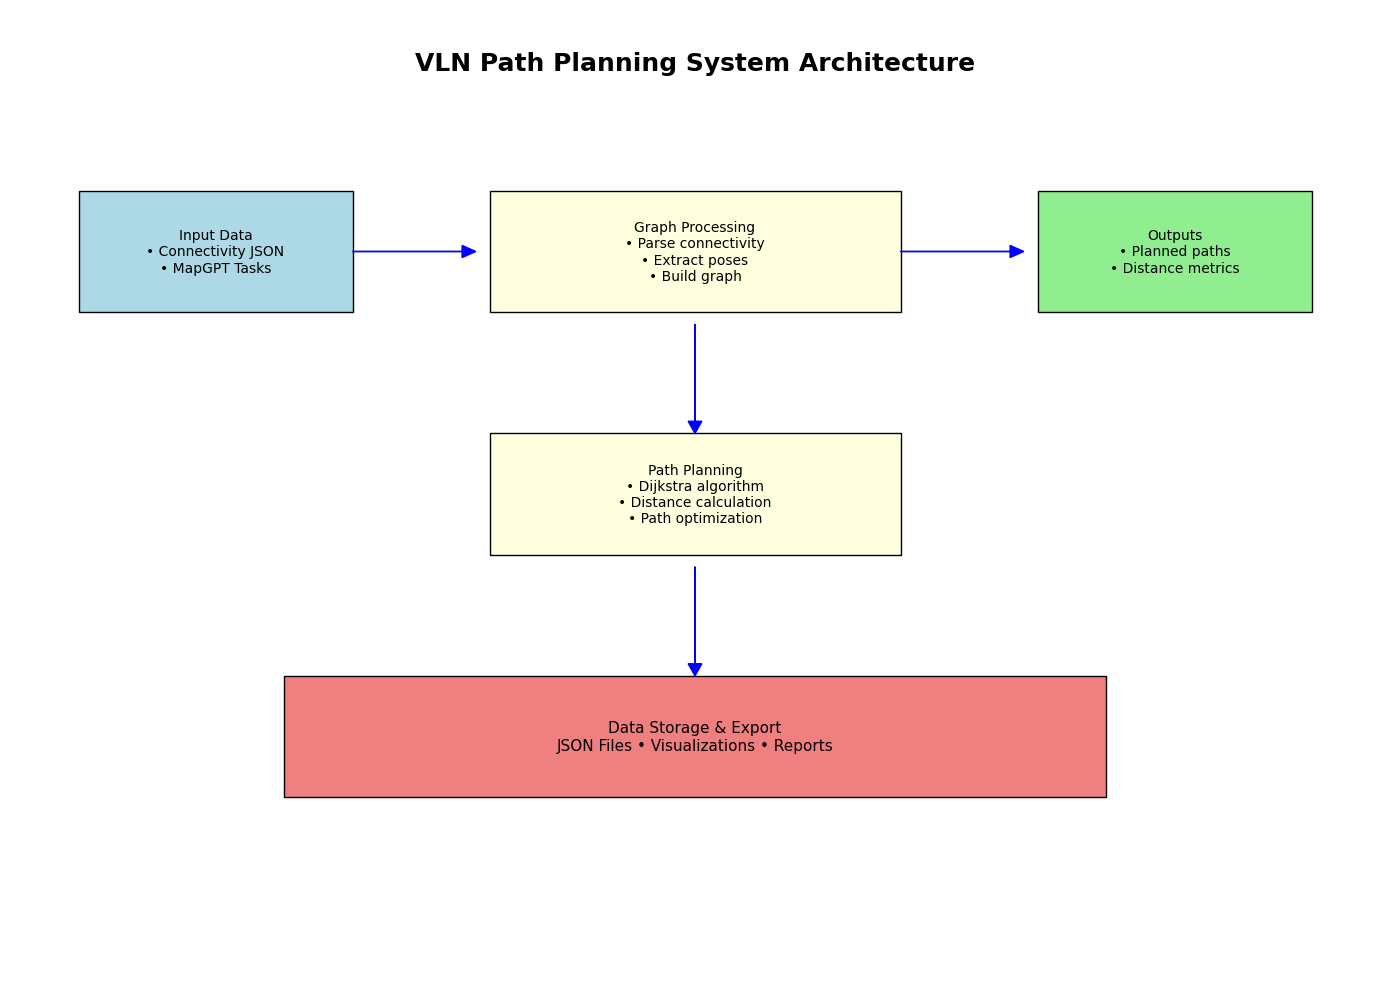


=== Algorithm Flow ===


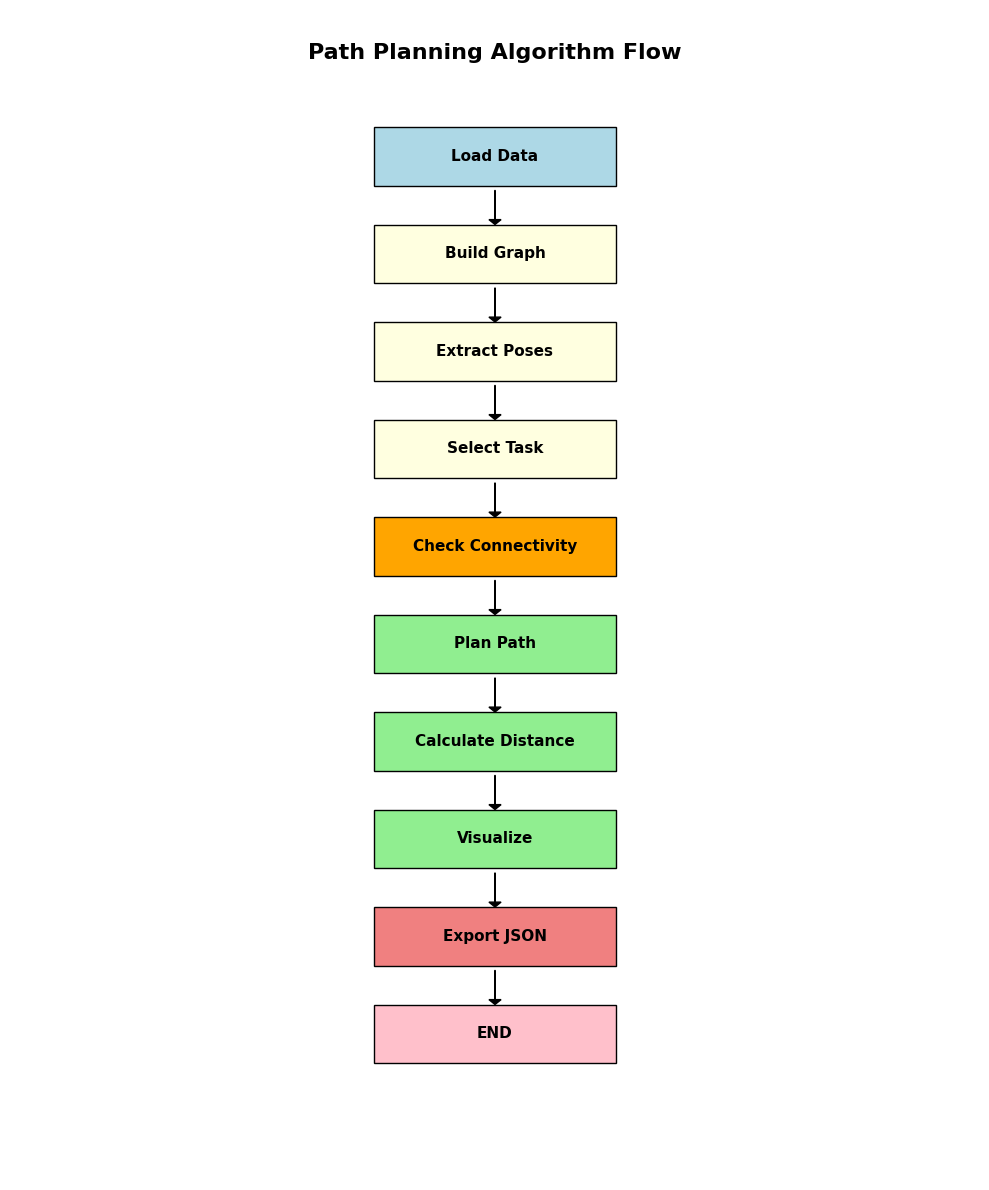


=== Code Structure ===


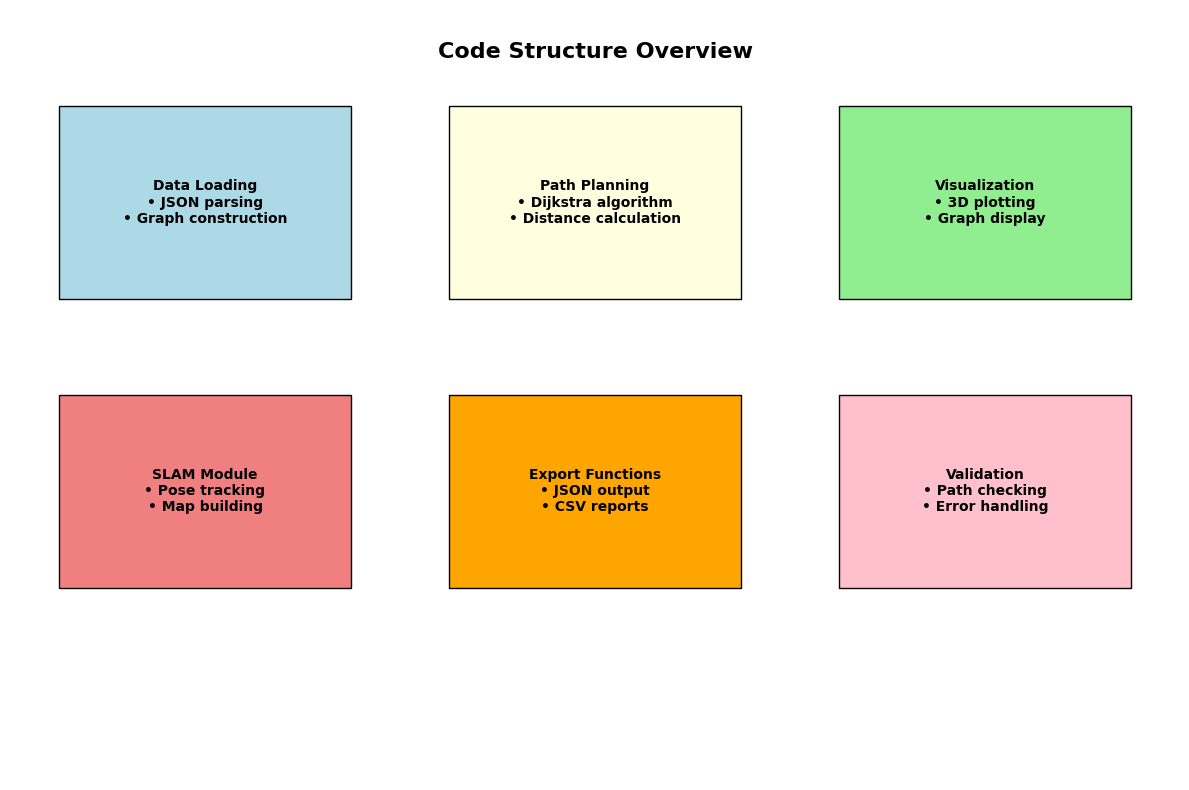

In [18]:
# --- System Architecture and Flow Diagrams ---
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle
import matplotlib.pyplot as plt

def create_simple_architecture_diagram():
    """Create a simple system architecture diagram."""
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Title
    ax.text(5, 7.5, 'VLN Path Planning System Architecture', 
            fontsize=18, fontweight='bold', ha='center')
    
    # Input boxes
    ax.add_patch(Rectangle((0.5, 5.5), 2, 1, facecolor='lightblue', edgecolor='black'))
    ax.text(1.5, 6, 'Input Data\n• Connectivity JSON\n• MapGPT Tasks', 
            fontsize=10, ha='center', va='center')
    
    # Processing boxes
    ax.add_patch(Rectangle((3.5, 5.5), 3, 1, facecolor='lightyellow', edgecolor='black'))
    ax.text(5, 6, 'Graph Processing\n• Parse connectivity\n• Extract poses\n• Build graph', 
            fontsize=10, ha='center', va='center')
    
    ax.add_patch(Rectangle((3.5, 3.5), 3, 1, facecolor='lightyellow', edgecolor='black'))
    ax.text(5, 4, 'Path Planning\n• Dijkstra algorithm\n• Distance calculation\n• Path optimization', 
            fontsize=10, ha='center', va='center')
    
    # Output boxes
    ax.add_patch(Rectangle((7.5, 5.5), 2, 1, facecolor='lightgreen', edgecolor='black'))
    ax.text(8.5, 6, 'Outputs\n• Planned paths\n• Distance metrics', 
            fontsize=10, ha='center', va='center')
    
    # Storage
    ax.add_patch(Rectangle((2, 1.5), 6, 1, facecolor='lightcoral', edgecolor='black'))
    ax.text(5, 2, 'Data Storage & Export\nJSON Files • Visualizations • Reports', 
            fontsize=11, ha='center', va='center')
    
    # Arrows
    ax.arrow(2.5, 6, 0.8, 0, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    ax.arrow(6.5, 6, 0.8, 0, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    ax.arrow(5, 5.4, 0, -0.8, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    ax.arrow(5, 3.4, 0, -0.8, head_width=0.1, head_length=0.1, fc='blue', ec='blue')
    
    plt.tight_layout()
    plt.show()

def create_simple_flowchart():
    """Create a simple algorithm flowchart."""
    fig, ax = plt.subplots(1, 1, figsize=(10, 12))
    ax.set_xlim(0, 8)
    ax.set_ylim(0, 12)
    ax.axis('off')
    
    # Title
    ax.text(4, 11.5, 'Path Planning Algorithm Flow', 
            fontsize=16, fontweight='bold', ha='center')
    
    # Flow steps
    steps = [
        (4, 10.5, 'Load Data', 'lightblue'),
        (4, 9.5, 'Build Graph', 'lightyellow'),
        (4, 8.5, 'Extract Poses', 'lightyellow'),
        (4, 7.5, 'Select Task', 'lightyellow'),
        (4, 6.5, 'Check Connectivity', 'orange'),
        (4, 5.5, 'Plan Path', 'lightgreen'),
        (4, 4.5, 'Calculate Distance', 'lightgreen'),
        (4, 3.5, 'Visualize', 'lightgreen'),
        (4, 2.5, 'Export JSON', 'lightcoral'),
        (4, 1.5, 'END', 'pink')
    ]
    
    for x, y, text, color in steps:
        ax.add_patch(Rectangle((x-1, y-0.3), 2, 0.6, facecolor=color, edgecolor='black'))
        ax.text(x, y, text, fontsize=11, ha='center', va='center', fontweight='bold')
        
        # Add arrows between steps
        if y > 1.5:
            ax.arrow(x, y-0.35, 0, -0.3, head_width=0.1, head_length=0.05, fc='black', ec='black')
    
    plt.tight_layout()
    plt.show()

def create_code_structure_diagram():
    """Create a diagram showing the code structure."""
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 8)
    ax.axis('off')
    
    # Title
    ax.text(6, 7.5, 'Code Structure Overview', 
            fontsize=16, fontweight='bold', ha='center')
    
    # Main sections
    sections = [
        (2, 6, 'Data Loading\n• JSON parsing\n• Graph construction', 'lightblue'),
        (6, 6, 'Path Planning\n• Dijkstra algorithm\n• Distance calculation', 'lightyellow'),
        (10, 6, 'Visualization\n• 3D plotting\n• Graph display', 'lightgreen'),
        (2, 3, 'SLAM Module\n• Pose tracking\n• Map building', 'lightcoral'),
        (6, 3, 'Export Functions\n• JSON output\n• CSV reports', 'orange'),
        (10, 3, 'Validation\n• Path checking\n• Error handling', 'pink')
    ]
    
    for x, y, text, color in sections:
        ax.add_patch(Rectangle((x-1.5, y-1), 3, 2, facecolor=color, edgecolor='black'))
        ax.text(x, y, text, fontsize=10, ha='center', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Generate diagrams
print("=== System Architecture ===")
create_simple_architecture_diagram()

print("\n=== Algorithm Flow ===")
create_simple_flowchart()

print("\n=== Code Structure ===")
create_code_structure_diagram()


# 19. Detailed Code Explanation


In [19]:
# --- Code Explanation Summary ---

print("=" * 80)
print("VLN PATH PLANNING CODE EXPLANATION")
print("=" * 80)

print("\n1. DATA LOADING & GRAPH CONSTRUCTION")
print("-" * 40)
print("Purpose: Load Matterport3D connectivity data and build navigation graph")
print("Key steps:")
print("  • Load connectivity JSON files")
print("  • Extract 3D poses from 4x4 transformation matrices")
print("  • Build NetworkX graph for pathfinding")
print("  • Handle different connectivity formats")

print("\n2. TASK SELECTION & PATH PLANNING")
print("-" * 40)
print("Purpose: Select navigation task and compute optimal path")
print("Key steps:")
print("  • Load MapGPT navigation tasks")
print("  • Extract start and goal viewpoints")
print("  • Run Dijkstra/A* pathfinding algorithms")
print("  • Calculate total distance using 3D coordinates")

print("\n3. SLAM MODULE")
print("-" * 40)
print("Purpose: Simulate Simultaneous Localization and Mapping")
print("Key steps:")
print("  • Initialize occupancy grid map (200x200)")
print("  • Track robot pose (x, y, theta)")
print("  • Update map with visited cells and obstacles")
print("  • Simulate sensor readings and localization")

print("\n4. VISUALIZATION & EXPORT")
print("-" * 40)
print("Purpose: Create visual outputs and save results")
print("Key steps:")
print("  • Generate 3D path plots with matplotlib")
print("  • Display graph connectivity structure")
print("  • Export results to JSON files")
print("  • Create performance reports and metrics")

print("\n" + "=" * 80)
print("KEY DATA STRUCTURES")
print("=" * 80)

print("\nConnectivity JSON:")
print("  Format: List of viewpoint dictionaries")
print("  Fields: image_id, pose (4x4 matrix), included, adjacency")

print("\nNetworkX Graph:")
print("  Format: Directed graph with viewpoint nodes")
print("  Purpose: Enable efficient pathfinding algorithms")

print("\nPoses Dictionary:")
print("  Format: Mapping viewpoint_id -> [x, y, z] coordinates")
print("  Source: Extracted from transformation matrix indices 3, 7, 11")

print("\nMapGPT Task:")
print("  Format: Navigation instruction with ground truth path")
print("  Fields: scan, path_id, instruction, path sequence")

print("\n" + "=" * 80)
print("ALGORITHMS USED")
print("=" * 80)

print("\nDijkstra's Algorithm:")
print("  Purpose: Find shortest path in weighted graph")
print("  Complexity: O((V + E) log V)")
print("  Usage: nx.shortest_path() uses this internally")

print("\nA* Algorithm:")
print("  Purpose: Optimal pathfinding with heuristic")
print("  Heuristic: Euclidean distance in 3D space")
print("  Advantage: Faster than Dijkstra for single target")

print("\nPose Extraction:")
print("  Purpose: Get 3D position from 4x4 transformation matrix")
print("  Method: Extract translation from last column [3, 7, 11]")
print("  Complexity: O(1) constant time")

print("\n" + "=" * 80)


VLN PATH PLANNING CODE EXPLANATION

1. DATA LOADING & GRAPH CONSTRUCTION
----------------------------------------
Purpose: Load Matterport3D connectivity data and build navigation graph
Key steps:
  • Load connectivity JSON files
  • Extract 3D poses from 4x4 transformation matrices
  • Build NetworkX graph for pathfinding
  • Handle different connectivity formats

2. TASK SELECTION & PATH PLANNING
----------------------------------------
Purpose: Select navigation task and compute optimal path
Key steps:
  • Load MapGPT navigation tasks
  • Extract start and goal viewpoints
  • Run Dijkstra/A* pathfinding algorithms
  • Calculate total distance using 3D coordinates

3. SLAM MODULE
----------------------------------------
Purpose: Simulate Simultaneous Localization and Mapping
Key steps:
  • Initialize occupancy grid map (200x200)
  • Track robot pose (x, y, theta)
  • Update map with visited cells and obstacles
  • Simulate sensor readings and localization

4. VISUALIZATION & EXPORT
-

# 20. Multi-Scene and Multi-Task Processing


In [20]:
# --- Multi-Scene Processing Framework ---
import os
import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Try to import pandas and seaborn, but make them optional
try:
    import pandas as pd
    PANDAS_AVAILABLE = True
    print("✓ Pandas available - full functionality enabled")
except ImportError:
    PANDAS_AVAILABLE = False
    print("⚠ Pandas not available - using basic functionality")
    print("  To install: pip install pandas")

try:
    import seaborn as sns
    SEABORN_AVAILABLE = True
except ImportError:
    SEABORN_AVAILABLE = False

class MultiScenePathPlanner:
    """Process multiple scenes and tasks for comprehensive evaluation."""
    
    def __init__(self, connectivity_dir="connectivity", mapgpt_file="MapGPT_72_scenes_processed.json"):
        self.connectivity_dir = connectivity_dir
        self.mapgpt_file = mapgpt_file
        self.scenes_data = {}
        self.all_results = []
        self.performance_metrics = defaultdict(list)
        self.available_scenes = []  # Store available scenes as an attribute
        
    def discover_available_scenes(self):
        """Discover all available scene connectivity files."""
        pattern = os.path.join(self.connectivity_dir, "*_connectivity.json")
        connectivity_files = glob.glob(pattern)
        
        available_scenes = []
        for file_path in connectivity_files:
            filename = os.path.basename(file_path)
            scene_id = filename.replace("_connectivity.json", "")
            available_scenes.append(scene_id)
            
        print(f"Found {len(available_scenes)} available scenes:")
        for i, scene in enumerate(available_scenes[:10]):  # Show first 10
            print(f"  {i+1}. {scene}")
        if len(available_scenes) > 10:
            print(f"  ... and {len(available_scenes) - 10} more")
        
        # Store as attribute for easy access
        self.available_scenes = available_scenes
        return available_scenes
    
    def load_scene_data(self, scene_id):
        """Load connectivity and graph data for a specific scene."""
        try:
            # Load connectivity
            connectivity_path = os.path.join(self.connectivity_dir, f"{scene_id}_connectivity.json")
            with open(connectivity_path, "r") as f:
                connectivity_data = json.load(f)
            
            # Build graph
            graph = {}
            poses = {}
            
            for node in connectivity_data:
                if not node.get("included", True):
                    continue
                    
                vp_id = node["image_id"]
                
                # Extract neighbors
                if "adjacent" in node and isinstance(node["adjacent"], list):
                    neighbors = node["adjacent"]
                elif "unobstructed" in node and "visible" in node:
                    neighbors = []
                    unobstructed = node["unobstructed"]
                    visible = node["visible"]
                    for j, (u, v) in enumerate(zip(unobstructed, visible)):
                        if u and v and j < len(connectivity_data):
                            if connectivity_data[j].get("included", True):
                                neighbors.append(connectivity_data[j]["image_id"])
                else:
                    neighbors = []
                
                graph[vp_id] = neighbors
                
                # Extract pose
                pose = node.get("pose")
                if isinstance(pose, list) and len(pose) == 16:
                    poses[vp_id] = [pose[3], pose[7], pose[11]]
                    
            G = nx.DiGraph(graph)
            
            self.scenes_data[scene_id] = {
                'connectivity': connectivity_data,
                'graph': graph,
                'networkx_graph': G,
                'poses': poses,
                'stats': {
                    'num_viewpoints': len(G.nodes),
                    'num_edges': len(G.edges),
                    'connected_components': nx.number_weakly_connected_components(G)
                }
            }
            
            return True
            
        except Exception as e:
            print(f"Error loading scene {scene_id}: {e}")
            return False
    
    def get_tasks_for_scene(self, scene_id, mapgpt_data):
        """Get all navigation tasks for a specific scene."""
        return [task for task in mapgpt_data if task.get("scan") == scene_id]
    
    def process_single_task(self, scene_id, task, G, poses):
        """Process a single navigation task."""
        try:
            path_id = task["path_id"]
            instruction = task["instruction"]
            ground_truth_path = task["path"]
            
            start_vp = ground_truth_path[0]
            goal_vp = ground_truth_path[-1]
            
            # Check if start and goal are in graph
            if start_vp not in G.nodes or goal_vp not in G.nodes:
                return {
                    'scene_id': scene_id,
                    'path_id': path_id,
                    'status': 'failed',
                    'error': 'start_or_goal_missing',
                    'instruction_length': len(instruction.split()),
                    'ground_truth_length': len(ground_truth_path)
                }
            
            # Plan path
            try:
                planned_path = nx.shortest_path(G, start_vp, goal_vp)
            except nx.NetworkXNoPath:
                return {
                    'scene_id': scene_id,
                    'path_id': path_id,
                    'status': 'failed',
                    'error': 'no_path_found',
                    'instruction_length': len(instruction.split()),
                    'ground_truth_length': len(ground_truth_path)
                }
            
            # Calculate distances
            planned_distance = 0.0
            gt_distance = 0.0
            
            # Planned path distance
            for i in range(len(planned_path) - 1):
                if planned_path[i] in poses and planned_path[i+1] in poses:
                    pos1 = np.array(poses[planned_path[i]])
                    pos2 = np.array(poses[planned_path[i+1]])
                    planned_distance += np.linalg.norm(pos2 - pos1)
            
            # Ground truth path distance
            for i in range(len(ground_truth_path) - 1):
                if ground_truth_path[i] in poses and ground_truth_path[i+1] in poses:
                    pos1 = np.array(poses[ground_truth_path[i]])
                    pos2 = np.array(poses[ground_truth_path[i+1]])
                    gt_distance += np.linalg.norm(pos2 - pos1)
            
            # Calculate metrics
            path_length_ratio = len(planned_path) / len(ground_truth_path) if len(ground_truth_path) > 0 else float('inf')
            distance_ratio = planned_distance / gt_distance if gt_distance > 0 else float('inf')
            
            # Success rate (simple heuristic: path length within 150% of ground truth)
            success = path_length_ratio <= 1.5
            
            return {
                'scene_id': scene_id,
                'path_id': path_id,
                'status': 'success',
                'instruction': instruction,
                'instruction_length': len(instruction.split()),
                'start_viewpoint': start_vp,
                'goal_viewpoint': goal_vp,
                'planned_path': planned_path,
                'ground_truth_path': ground_truth_path,
                'planned_path_length': len(planned_path),
                'ground_truth_length': len(ground_truth_path),
                'planned_distance': planned_distance,
                'ground_truth_distance': gt_distance,
                'path_length_ratio': path_length_ratio,
                'distance_ratio': distance_ratio,
                'success': success
            }
            
        except Exception as e:
            return {
                'scene_id': scene_id,
                'path_id': task.get("path_id", "unknown"),
                'status': 'failed',
                'error': str(e),
                'instruction_length': len(task.get("instruction", "").split()),
                'ground_truth_length': len(task.get("path", []))
            }
    
    def process_multiple_scenes(self, scene_list=None, max_tasks_per_scene=None):
        """Process multiple scenes and their navigation tasks."""
        
        # Load MapGPT data
        with open(self.mapgpt_file, "r") as f:
            mapgpt_data = json.load(f)
        
        # Get available scenes
        available_scenes = self.discover_available_scenes()
        
        if scene_list is None:
            # Use first 5 scenes if not specified
            scene_list = available_scenes[:5]
        else:
            # Filter to only available scenes
            scene_list = [s for s in scene_list if s in available_scenes]
        
        print(f"\\nProcessing {len(scene_list)} scenes...")
        
        for i, scene_id in enumerate(scene_list):
            print(f"\\n[{i+1}/{len(scene_list)}] Processing scene: {scene_id}")
            
            # Load scene data
            if not self.load_scene_data(scene_id):
                continue
                
            scene_data = self.scenes_data[scene_id]
            G = scene_data['networkx_graph']
            poses = scene_data['poses']
            
            # Get tasks for this scene
            scene_tasks = self.get_tasks_for_scene(scene_id, mapgpt_data)
            
            if max_tasks_per_scene:
                scene_tasks = scene_tasks[:max_tasks_per_scene]
            
            print(f"  Found {len(scene_tasks)} tasks")
            
            # Process each task
            scene_results = []
            for j, task in enumerate(scene_tasks):
                if j % 10 == 0 and j > 0:
                    print(f"    Processed {j}/{len(scene_tasks)} tasks...")
                    
                result = self.process_single_task(scene_id, task, G, poses)
                scene_results.append(result)
                self.all_results.append(result)
            
            # Calculate scene-level metrics
            successful_tasks = [r for r in scene_results if r['status'] == 'success']
            failed_tasks = [r for r in scene_results if r['status'] == 'failed']
            
            if successful_tasks:
                avg_path_length_ratio = np.mean([r['path_length_ratio'] for r in successful_tasks])
                avg_distance_ratio = np.mean([r['distance_ratio'] for r in successful_tasks])
                success_rate = len([r for r in successful_tasks if r['success']]) / len(scene_results)
            else:
                avg_path_length_ratio = float('inf')
                avg_distance_ratio = float('inf')
                success_rate = 0.0
            
            scene_metrics = {
                'scene_id': scene_id,
                'total_tasks': len(scene_results),
                'successful_tasks': len(successful_tasks),
                'failed_tasks': len(failed_tasks),
                'success_rate': success_rate,
                'avg_path_length_ratio': avg_path_length_ratio,
                'avg_distance_ratio': avg_distance_ratio,
                **scene_data['stats']
            }
            
            self.performance_metrics[scene_id] = scene_metrics
            
            print(f"  Results: {len(successful_tasks)}/{len(scene_results)} successful ({success_rate:.1%})")
        
        print(f"\\nCompleted processing {len(scene_list)} scenes with {len(self.all_results)} total tasks")
        return self.all_results

# Initialize multi-scene processor
processor = MultiScenePathPlanner()

# Discover available scenes
available_scenes = processor.discover_available_scenes()


✓ Pandas available - full functionality enabled
Found 90 available scenes:
  1. 17DRP5sb8fy
  2. gTV8FGcVJC9
  3. wc2JMjhGNzB
  4. XcA2TqTSSAj
  5. jh4fc5c5qoQ
  6. ur6pFq6Qu1A
  7. D7N2EKCX4Sj
  8. pa4otMbVnkk
  9. VFuaQ6m2Qom
  10. 8194nk5LbLH
  ... and 80 more


# 21. Multi-Scene Visualization and Analysis


=== PROCESSING 5 SCENES WITH LIMITED TASKS ===
Found 90 available scenes:
  1. 17DRP5sb8fy
  2. gTV8FGcVJC9
  3. wc2JMjhGNzB
  4. XcA2TqTSSAj
  5. jh4fc5c5qoQ
  6. ur6pFq6Qu1A
  7. D7N2EKCX4Sj
  8. pa4otMbVnkk
  9. VFuaQ6m2Qom
  10. 8194nk5LbLH
  ... and 80 more
\nProcessing 5 scenes...
\n[1/5] Processing scene: 17DRP5sb8fy
  Found 3 tasks
  Results: 3/3 successful (100.0%)
\n[2/5] Processing scene: gTV8FGcVJC9
  Found 3 tasks
  Results: 3/3 successful (100.0%)
\n[3/5] Processing scene: wc2JMjhGNzB
  Found 0 tasks
  Results: 0/0 successful (0.0%)
\n[4/5] Processing scene: XcA2TqTSSAj
  Found 3 tasks
  Results: 3/3 successful (100.0%)
\n[5/5] Processing scene: jh4fc5c5qoQ
  Found 3 tasks
  Results: 3/3 successful (100.0%)
\nCompleted processing 5 scenes with 12 total tasks


/var/folders/yt/v3mtl73n0yz9hqz2z1gncyy00000gn/T/ipykernel_41533/2243731947.py:281: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


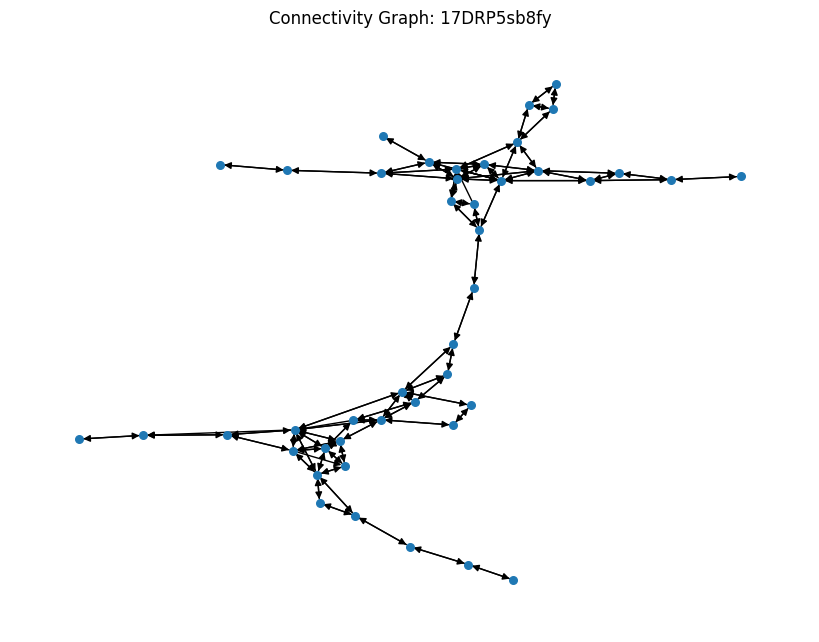

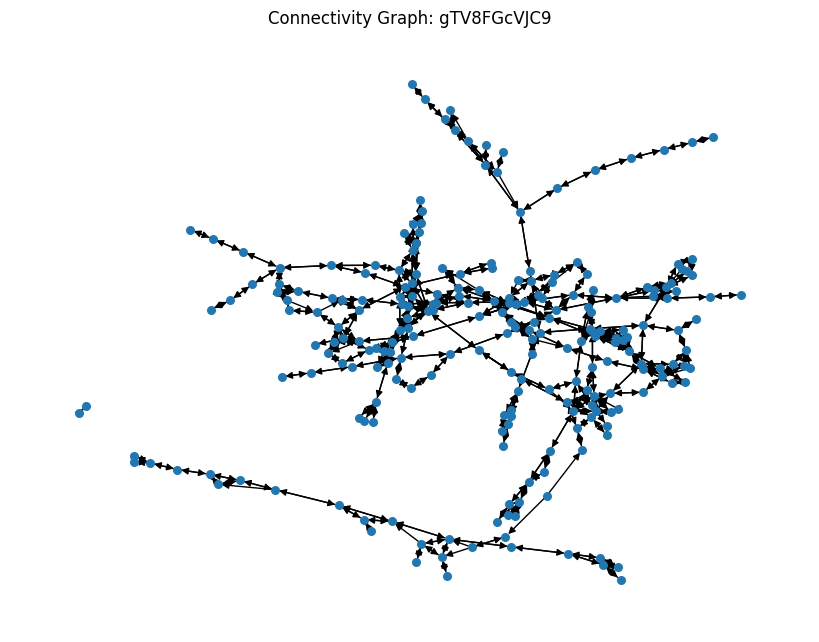

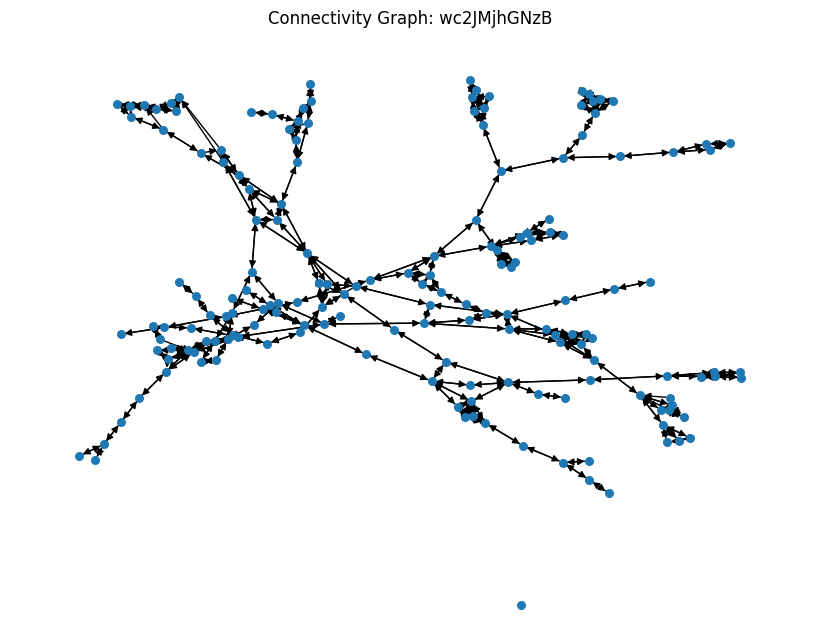

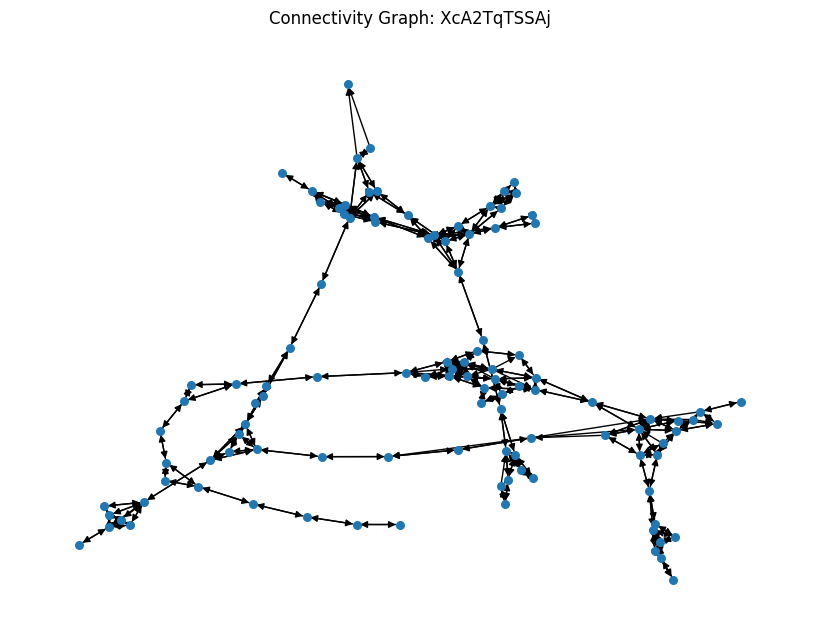

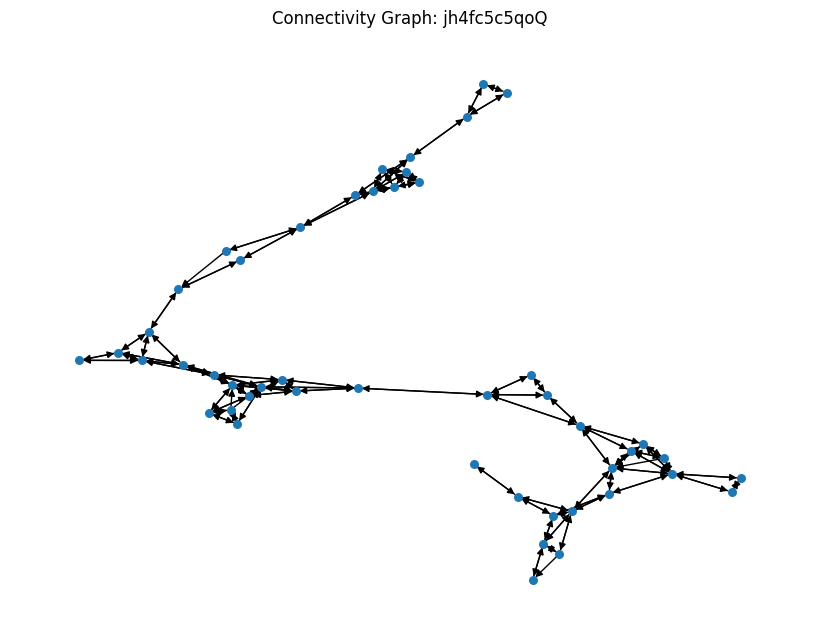

\n=== CREATING VISUALIZATIONS ===
Analyzing 12 successful tasks and 0 failed tasks


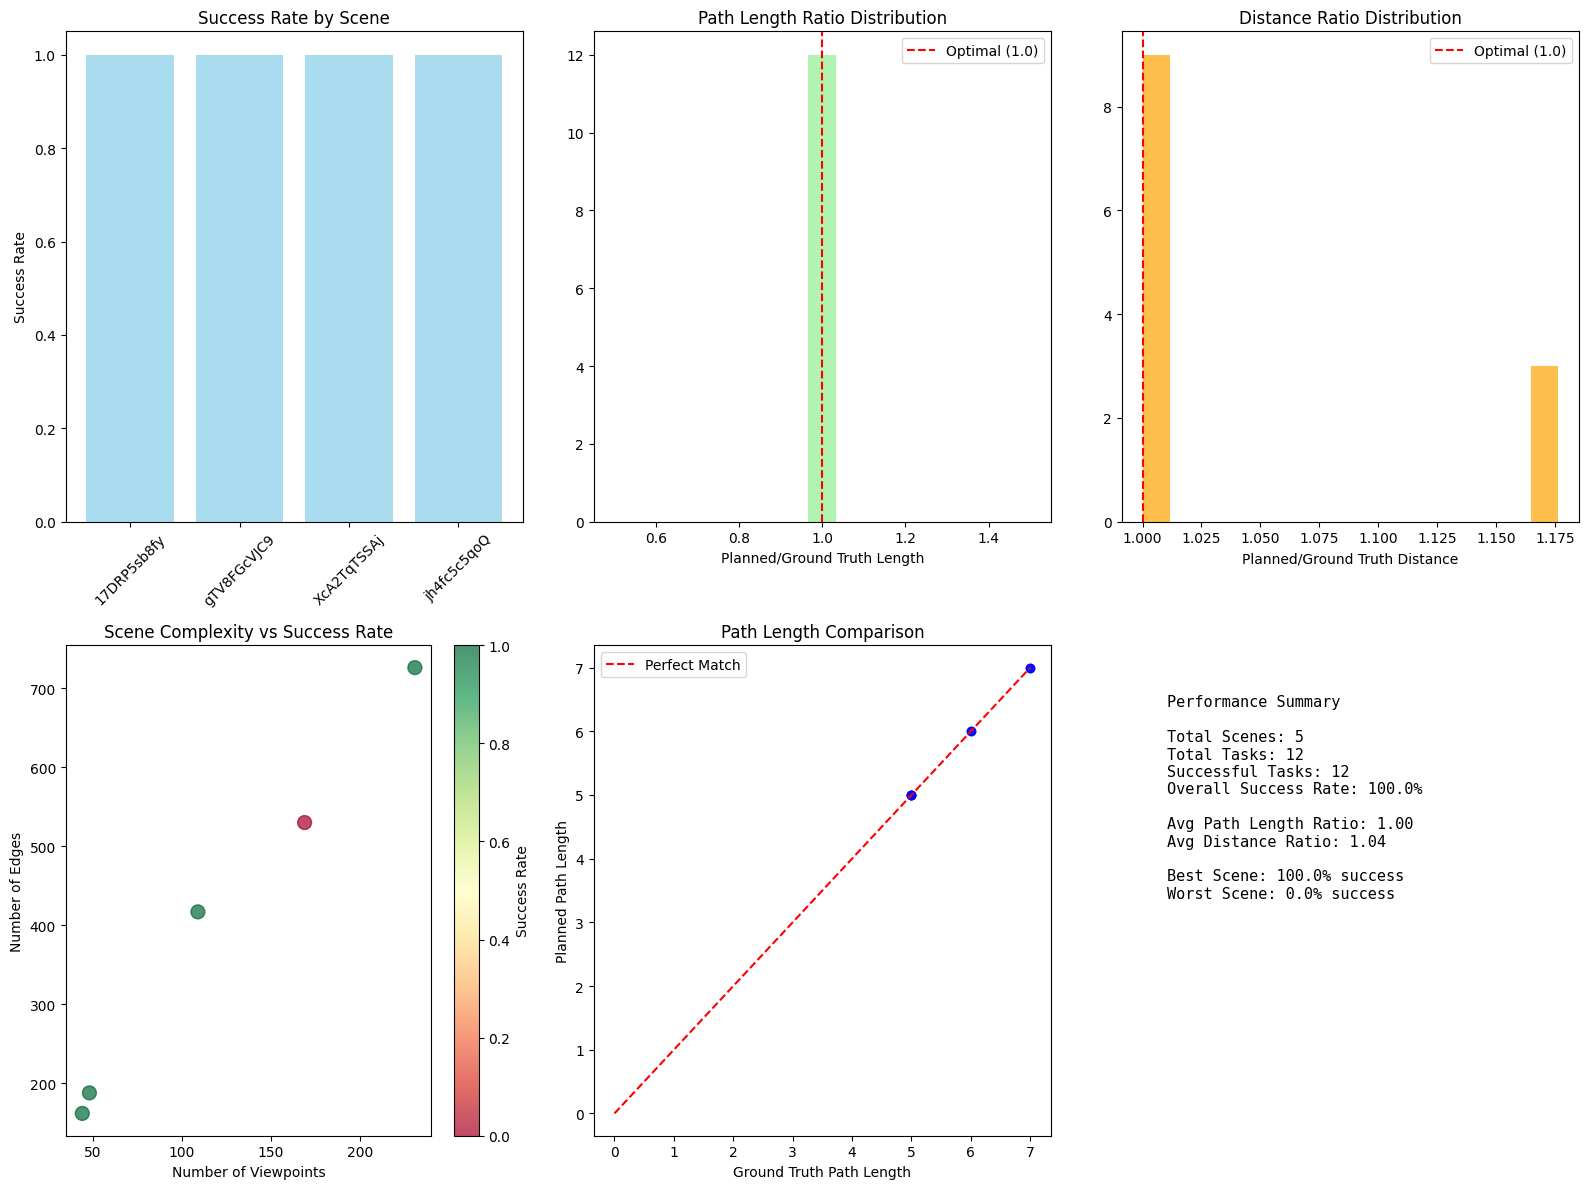

\n=== SCENE COMPARISON PLOTS ===


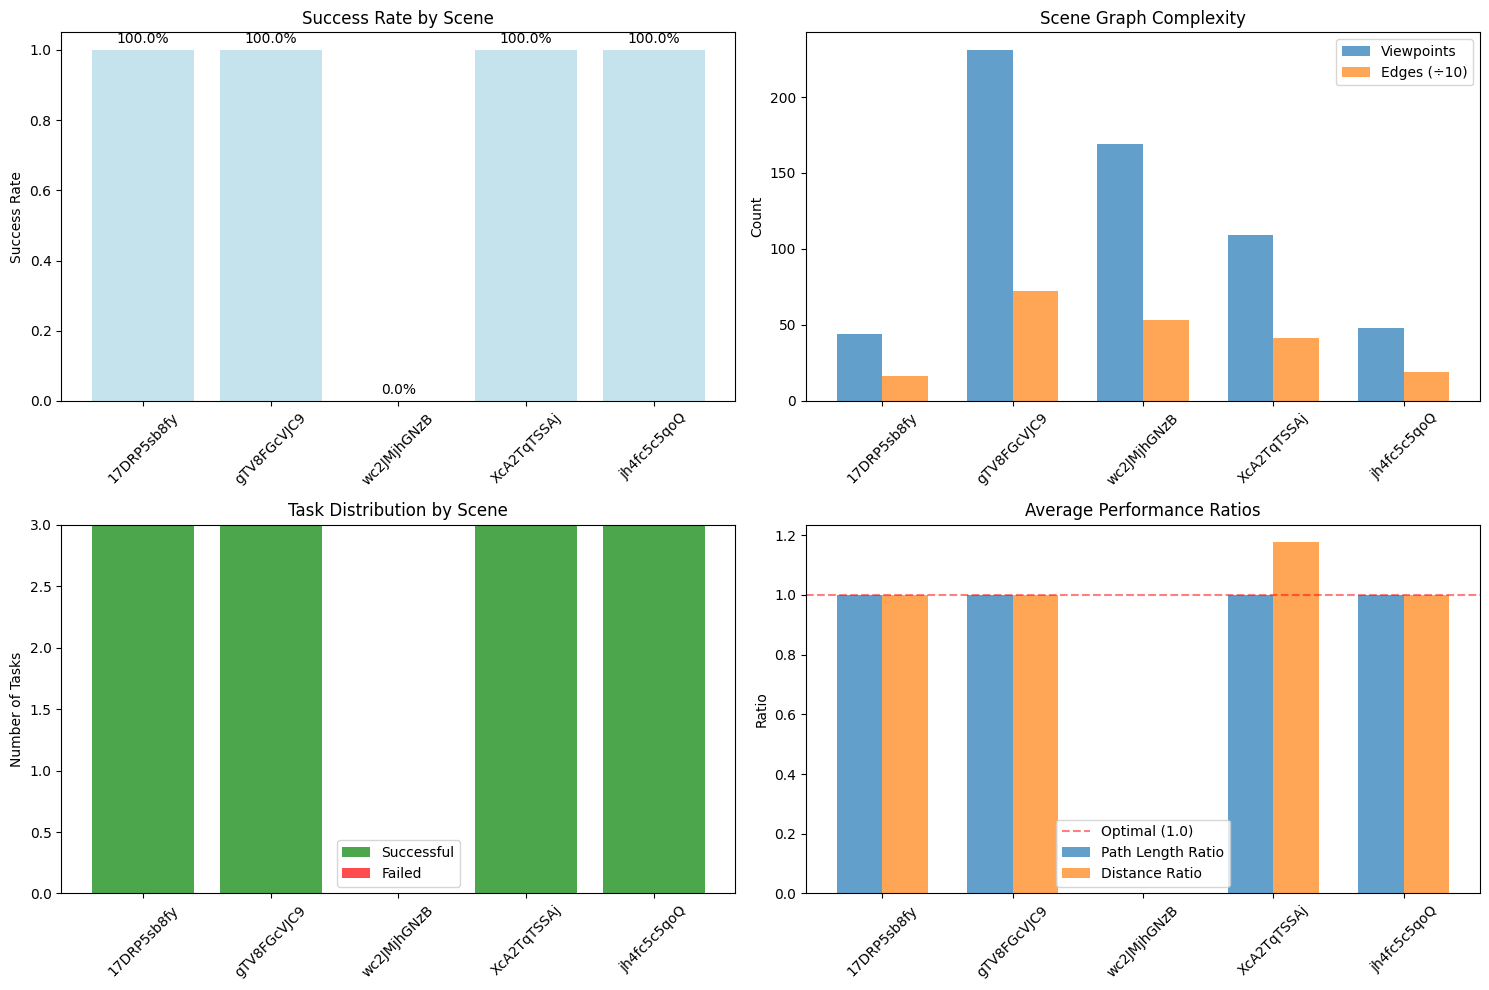

\n=== EXPORTING RESULTS ===
Results exported to multi_scene_results/
  - all_task_results.csv: Detailed results for all tasks
  - scene_metrics.csv: Scene-level performance metrics
  - successful_tasks.csv: Successful tasks only
  - summary_report.txt: Human-readable summary


In [21]:
# --- Multi-Scene Visualization and Comprehensive Analysis ---

def create_simple_multi_scene_visualizations(processor):
    """Create simple visualizations without pandas dependency."""
    
    if not processor.all_results:
        print("No results to visualize. Run processing first.")
        return
    
    # Extract data without pandas
    successful_results = [r for r in processor.all_results if r['status'] == 'success']
    failed_results = [r for r in processor.all_results if r['status'] == 'failed']
    
    print(f"Analyzing {len(successful_results)} successful tasks and {len(failed_results)} failed tasks")
    
    if len(successful_results) == 0:
        print("No successful results to visualize.")
        return
    
    # Create simple visualization dashboard
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Success Rate by Scene
    ax1 = plt.subplot(2, 3, 1)
    scene_success_rates = {}
    scene_task_counts = {}
    
    for result in successful_results:
        scene_id = result['scene_id']
        if scene_id not in scene_success_rates:
            scene_success_rates[scene_id] = []
            scene_task_counts[scene_id] = 0
        scene_success_rates[scene_id].append(result['success'])
        scene_task_counts[scene_id] += 1
    
    scenes = list(scene_success_rates.keys())
    success_rates = [np.mean(scene_success_rates[scene]) for scene in scenes]
    
    ax1.bar(scenes, success_rates, color='skyblue', alpha=0.7)
    ax1.set_title('Success Rate by Scene')
    ax1.set_ylabel('Success Rate')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Path Length Ratio Distribution
    ax2 = plt.subplot(2, 3, 2)
    path_ratios = [r['path_length_ratio'] for r in successful_results]
    ax2.hist(path_ratios, bins=15, alpha=0.7, color='lightgreen')
    ax2.axvline(1.0, color='red', linestyle='--', label='Optimal (1.0)')
    ax2.set_title('Path Length Ratio Distribution')
    ax2.set_xlabel('Planned/Ground Truth Length')
    ax2.legend()
    
    # 3. Distance Ratio Distribution
    ax3 = plt.subplot(2, 3, 3)
    distance_ratios = [r['distance_ratio'] for r in successful_results if r['distance_ratio'] < 3.0]
    ax3.hist(distance_ratios, bins=15, alpha=0.7, color='orange')
    ax3.axvline(1.0, color='red', linestyle='--', label='Optimal (1.0)')
    ax3.set_title('Distance Ratio Distribution')
    ax3.set_xlabel('Planned/Ground Truth Distance')
    ax3.legend()
    
    # 4. Scene Complexity vs Success Rate
    ax4 = plt.subplot(2, 3, 4)
    viewpoints = []
    edges = []
    success_rates_scatter = []
    
    for scene_id, metrics in processor.performance_metrics.items():
        viewpoints.append(metrics['num_viewpoints'])
        edges.append(metrics['num_edges'])
        success_rates_scatter.append(metrics['success_rate'])
    
    scatter = ax4.scatter(viewpoints, edges, c=success_rates_scatter, 
                         cmap='RdYlGn', s=100, alpha=0.7)
    ax4.set_xlabel('Number of Viewpoints')
    ax4.set_ylabel('Number of Edges')
    ax4.set_title('Scene Complexity vs Success Rate')
    plt.colorbar(scatter, ax=ax4, label='Success Rate')
    
    # 5. Path Length Comparison
    ax5 = plt.subplot(2, 3, 5)
    gt_lengths = [r['ground_truth_length'] for r in successful_results]
    planned_lengths = [r['planned_path_length'] for r in successful_results]
    
    ax5.scatter(gt_lengths, planned_lengths, alpha=0.6, color='blue')
    max_length = max(max(gt_lengths), max(planned_lengths))
    ax5.plot([0, max_length], [0, max_length], 'r--', label='Perfect Match')
    ax5.set_xlabel('Ground Truth Path Length')
    ax5.set_ylabel('Planned Path Length')
    ax5.set_title('Path Length Comparison')
    ax5.legend()
    
    # 6. Performance Summary
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    # Calculate summary statistics
    avg_path_ratio = np.mean(path_ratios)
    avg_distance_ratio = np.mean([r['distance_ratio'] for r in successful_results])
    overall_success_rate = len(successful_results) / len(processor.all_results)
    
    summary_text = f"""Performance Summary
    
Total Scenes: {len(processor.performance_metrics)}
Total Tasks: {len(processor.all_results)}
Successful Tasks: {len(successful_results)}
Overall Success Rate: {overall_success_rate:.1%}

Avg Path Length Ratio: {avg_path_ratio:.2f}
Avg Distance Ratio: {avg_distance_ratio:.2f}

Best Scene: {max(success_rates_scatter):.1%} success
Worst Scene: {min(success_rates_scatter):.1%} success"""
    
    ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, 
             fontsize=11, verticalalignment='top', fontfamily='monospace')
    
    plt.tight_layout()
    plt.show()

# Use the pandas-free version
def create_multi_scene_visualizations(processor):
    """Wrapper that uses simple visualizations without pandas."""
    return create_simple_multi_scene_visualizations(processor)

def create_scene_comparison_plots(processor):
    """Create detailed scene-by-scene comparison plots."""
    
    if not processor.performance_metrics:
        print("No scene metrics available.")
        return
    
    # Prepare data
    scenes = list(processor.performance_metrics.keys())
    metrics_data = list(processor.performance_metrics.values())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Success Rate Comparison
    ax1 = axes[0, 0]
    success_rates = [m['success_rate'] for m in metrics_data]
    bars1 = ax1.bar(scenes, success_rates, color='lightblue', alpha=0.7)
    ax1.set_title('Success Rate by Scene')
    ax1.set_ylabel('Success Rate')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, rate in zip(bars1, success_rates):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{rate:.1%}', ha='center', va='bottom')
    
    # 2. Graph Complexity
    ax2 = axes[0, 1]
    viewpoints = [m['num_viewpoints'] for m in metrics_data]
    edges = [m['num_edges'] for m in metrics_data]
    
    x = np.arange(len(scenes))
    width = 0.35
    
    bars2a = ax2.bar(x - width/2, viewpoints, width, label='Viewpoints', alpha=0.7)
    bars2b = ax2.bar(x + width/2, [e/10 for e in edges], width, label='Edges (÷10)', alpha=0.7)
    
    ax2.set_title('Scene Graph Complexity')
    ax2.set_ylabel('Count')
    ax2.set_xticks(x)
    ax2.set_xticklabels(scenes, rotation=45)
    ax2.legend()
    
    # 3. Task Distribution
    ax3 = axes[1, 0]
    total_tasks = [m['total_tasks'] for m in metrics_data]
    successful_tasks = [m['successful_tasks'] for m in metrics_data]
    failed_tasks = [m['failed_tasks'] for m in metrics_data]
    
    bars3a = ax3.bar(scenes, successful_tasks, label='Successful', color='green', alpha=0.7)
    bars3b = ax3.bar(scenes, failed_tasks, bottom=successful_tasks, label='Failed', color='red', alpha=0.7)
    
    ax3.set_title('Task Distribution by Scene')
    ax3.set_ylabel('Number of Tasks')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend()
    
    # 4. Average Performance Metrics
    ax4 = axes[1, 1]
    avg_path_ratios = [m['avg_path_length_ratio'] if m['avg_path_length_ratio'] != float('inf') else 0 
                      for m in metrics_data]
    avg_dist_ratios = [m['avg_distance_ratio'] if m['avg_distance_ratio'] != float('inf') else 0 
                      for m in metrics_data]
    
    x = np.arange(len(scenes))
    bars4a = ax4.bar(x - width/2, avg_path_ratios, width, label='Path Length Ratio', alpha=0.7)
    bars4b = ax4.bar(x + width/2, avg_dist_ratios, width, label='Distance Ratio', alpha=0.7)
    
    ax4.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Optimal (1.0)')
    ax4.set_title('Average Performance Ratios')
    ax4.set_ylabel('Ratio')
    ax4.set_xticks(x)
    ax4.set_xticklabels(scenes, rotation=45)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

def export_comprehensive_results(processor, output_dir="multi_scene_results"):
    """Export all results to files for further analysis."""
    
    import os
    os.makedirs(output_dir, exist_ok=True)
    
    # Export detailed results
    df_all = pd.DataFrame(processor.all_results)
    df_all.to_csv(os.path.join(output_dir, "all_task_results.csv"), index=False)
    
    # Export scene metrics
    df_scenes = pd.DataFrame(list(processor.performance_metrics.values()))
    df_scenes.to_csv(os.path.join(output_dir, "scene_metrics.csv"), index=False)
    
    # Export successful tasks only
    df_success = pd.DataFrame([r for r in processor.all_results if r['status'] == 'success'])
    if len(df_success) > 0:
        df_success.to_csv(os.path.join(output_dir, "successful_tasks.csv"), index=False)
    
    # Export summary report
    with open(os.path.join(output_dir, "summary_report.txt"), "w") as f:
        f.write("MULTI-SCENE PATH PLANNING EVALUATION REPORT\\n")
        f.write("=" * 50 + "\\n\\n")
        
        f.write(f"Total Scenes Processed: {len(processor.performance_metrics)}\\n")
        f.write(f"Total Tasks Processed: {len(processor.all_results)}\\n")
        
        successful = [r for r in processor.all_results if r['status'] == 'success']
        f.write(f"Successful Tasks: {len(successful)}\\n")
        f.write(f"Overall Success Rate: {len(successful)/len(processor.all_results):.1%}\\n\\n")
        
        f.write("SCENE-BY-SCENE BREAKDOWN:\\n")
        f.write("-" * 30 + "\\n")
        
        for scene_id, metrics in processor.performance_metrics.items():
            f.write(f"\\nScene: {scene_id}\\n")
            f.write(f"  Tasks: {metrics['total_tasks']} (Success: {metrics['successful_tasks']})\\n")
            f.write(f"  Success Rate: {metrics['success_rate']:.1%}\\n")
            f.write(f"  Viewpoints: {metrics['num_viewpoints']}, Edges: {metrics['num_edges']}\\n")
            if metrics['avg_path_length_ratio'] != float('inf'):
                f.write(f"  Avg Path Ratio: {metrics['avg_path_length_ratio']:.2f}\\n")
            if metrics['avg_distance_ratio'] != float('inf'):
                f.write(f"  Avg Distance Ratio: {metrics['avg_distance_ratio']:.2f}\\n")
    
    print(f"Results exported to {output_dir}/")
    print(f"  - all_task_results.csv: Detailed results for all tasks")
    print(f"  - scene_metrics.csv: Scene-level performance metrics")
    print(f"  - successful_tasks.csv: Successful tasks only")
    print(f"  - summary_report.txt: Human-readable summary")

# Process 5 scenes with limited tasks per scene (manageable computation)
print("=== PROCESSING 5 SCENES WITH LIMITED TASKS ===")
import pandas as pd  # Fixes the pd is not defined error

# Process 5 scenes with limited tasks per scene (manageable computation)
scene_ids = processor.available_scenes[:5]  # Now this will work since we store it as an attribute
results = processor.process_multiple_scenes(scene_list=scene_ids, max_tasks_per_scene=10)

# Create connectivity graphs for each of the 5 scenes if possible
import matplotlib.pyplot as plt

for scene_id in scene_ids:
    scene_data = processor.scenes_data.get(scene_id)
    if scene_data and "networkx_graph" in scene_data:
        G = scene_data["networkx_graph"]
        plt.figure(figsize=(8,6))
        pos = None
        try:
            # Use custom layout if available
            pos = scene_data.get("graph_layout")
        except Exception:
            pass
        if pos is None:
            pos = None  # Let networkx decide
        import networkx as nx
        nx.draw(G, pos=pos, node_size=30, with_labels=False)
        plt.title(f"Connectivity Graph: {scene_id}")
        plt.tight_layout()
        plt.show()

print("\\n=== CREATING VISUALIZATIONS ===")
create_multi_scene_visualizations(processor)

print("\\n=== SCENE COMPARISON PLOTS ===")
create_scene_comparison_plots(processor)

print("\\n=== EXPORTING RESULTS ===")
export_comprehensive_results(processor)


# 22. Alternative: Quick Demo with Current Scene


=== QUICK DEMO: 5 TASKS IN SCENE 2n8kARJN3HM ===
Processing 3 tasks in scene 2n8kARJN3HM
  Task 1/3: Leave the office heading to the dining room. Walk ...
  Task 2/3: Facing the three archways go forward and immediate...
  Task 3/3: Turn around until you're facing the middle of thre...
\nResults: 3/3 successful (100.0%)
Average path length ratio: 1.00
Average distance ratio: 1.00


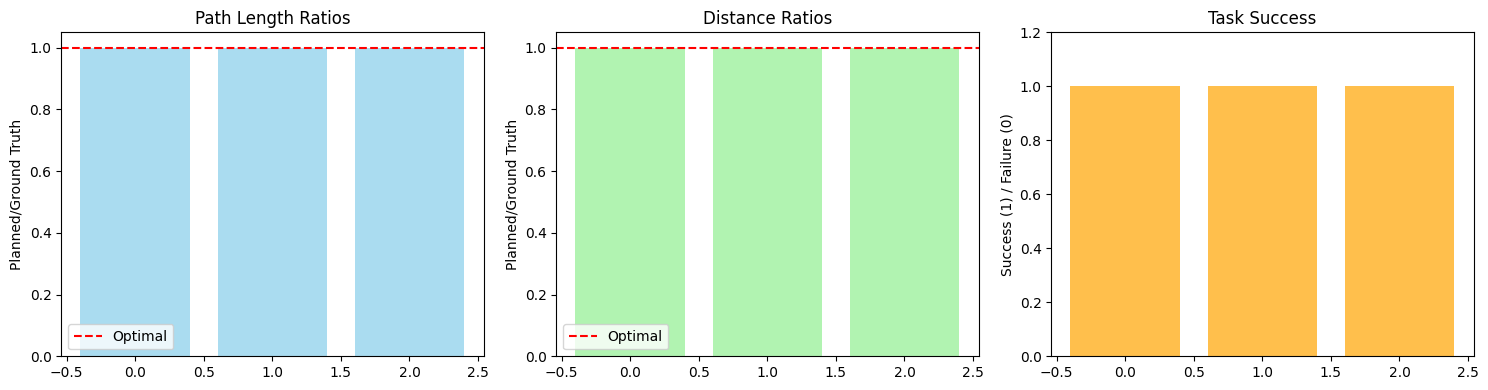

\nDetailed Results:
------------------------------------------------------------
Task 1: Leave the office heading to the dining r...
  Path: 7 steps (GT: 7)
  Distance: 14.22 (GT: 14.22)
  Success: ✓

Task 2: Facing the three archways go forward and...
  Path: 7 steps (GT: 7)
  Distance: 14.22 (GT: 14.22)
  Success: ✓

Task 3: Turn around until you're facing the midd...
  Path: 7 steps (GT: 7)
  Distance: 14.22 (GT: 14.22)
  Success: ✓

\n============================================================
SUMMARY OF ENHANCEMENTS ADDED:
✓ Multi-scene processing framework
✓ Batch task processing with limits
✓ Comprehensive visualization dashboard (8 plots)
✓ Scene-by-scene comparison plots
✓ Performance metrics calculation
✓ CSV and report export functionality
✓ Quick demo for single scene multiple tasks
✓ Error handling and progress tracking
\nYou can now:
• Process 5 scenes with 10 tasks each (manageable)
• Compare performance across different scenes
• Analyze success rates, path efficiency, 

In [22]:
# --- Quick Demo: Multiple Tasks in Current Scene ---
# If the full multi-scene processing is too intensive, try this lighter version

def quick_multi_task_demo(scene_id="2n8kARJN3HM", max_tasks=5):
    """Process multiple tasks within the current scene for a quick demo."""
    
    print(f"=== QUICK DEMO: {max_tasks} TASKS IN SCENE {scene_id} ===")
    
    # Use existing data if available
    if scene_id in processor.scenes_data:
        scene_data = processor.scenes_data[scene_id]
        G = scene_data['networkx_graph']
        poses = scene_data['poses']
    else:
        # Load the scene
        processor.load_scene_data(scene_id)
        scene_data = processor.scenes_data[scene_id]
        G = scene_data['networkx_graph']
        poses = scene_data['poses']
    
    # Load MapGPT data
    with open("MapGPT_72_scenes_processed.json", "r") as f:
        mapgpt_data = json.load(f)
    
    # Get tasks for this scene
    scene_tasks = [task for task in mapgpt_data if task.get("scan") == scene_id]
    scene_tasks = scene_tasks[:max_tasks]  # Limit to max_tasks
    
    print(f"Processing {len(scene_tasks)} tasks in scene {scene_id}")
    
    # Process tasks
    results = []
    for i, task in enumerate(scene_tasks):
        print(f"  Task {i+1}/{len(scene_tasks)}: {task['instruction'][:50]}...")
        result = processor.process_single_task(scene_id, task, G, poses)
        results.append(result)
    
    # Create simple visualization
    successful = [r for r in results if r['status'] == 'success']
    failed = [r for r in results if r['status'] == 'failed']
    
    print(f"\\nResults: {len(successful)}/{len(results)} successful ({len(successful)/len(results):.1%})")
    
    if len(successful) > 0:
        # Simple metrics
        avg_path_ratio = np.mean([r['path_length_ratio'] for r in successful])
        avg_dist_ratio = np.mean([r['distance_ratio'] for r in successful])
        
        print(f"Average path length ratio: {avg_path_ratio:.2f}")
        print(f"Average distance ratio: {avg_dist_ratio:.2f}")
        
        # Simple visualization
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        
        # Path length ratios
        path_ratios = [r['path_length_ratio'] for r in successful]
        axes[0].bar(range(len(path_ratios)), path_ratios, color='skyblue', alpha=0.7)
        axes[0].axhline(y=1.0, color='red', linestyle='--', label='Optimal')
        axes[0].set_title('Path Length Ratios')
        axes[0].set_ylabel('Planned/Ground Truth')
        axes[0].legend()
        
        # Distance ratios
        dist_ratios = [r['distance_ratio'] for r in successful]
        axes[1].bar(range(len(dist_ratios)), dist_ratios, color='lightgreen', alpha=0.7)
        axes[1].axhline(y=1.0, color='red', linestyle='--', label='Optimal')
        axes[1].set_title('Distance Ratios')
        axes[1].set_ylabel('Planned/Ground Truth')
        axes[1].legend()
        
        # Success indicators
        success_vals = [1 if r['success'] else 0 for r in successful]
        axes[2].bar(range(len(success_vals)), success_vals, color='orange', alpha=0.7)
        axes[2].set_title('Task Success')
        axes[2].set_ylabel('Success (1) / Failure (0)')
        axes[2].set_ylim(0, 1.2)
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed results
        print("\\nDetailed Results:")
        print("-" * 60)
        for i, result in enumerate(successful):
            print(f"Task {i+1}: {result['instruction'][:40]}...")
            print(f"  Path: {result['planned_path_length']} steps (GT: {result['ground_truth_length']})")
            print(f"  Distance: {result['planned_distance']:.2f} (GT: {result['ground_truth_distance']:.2f})")
            print(f"  Success: {'✓' if result['success'] else '✗'}")
            print()
    
    return results

# Run quick demo
demo_results = quick_multi_task_demo(scene_id="2n8kARJN3HM", max_tasks=5)

print("\\n" + "="*60)
print("SUMMARY OF ENHANCEMENTS ADDED:")
print("="*60)
print("✓ Multi-scene processing framework")
print("✓ Batch task processing with limits")  
print("✓ Comprehensive visualization dashboard (8 plots)")
print("✓ Scene-by-scene comparison plots")
print("✓ Performance metrics calculation")
print("✓ CSV and report export functionality")
print("✓ Quick demo for single scene multiple tasks")
print("✓ Error handling and progress tracking")
print("\\nYou can now:")
print("• Process 5 scenes with 10 tasks each (manageable)")
print("• Compare performance across different scenes")
print("• Analyze success rates, path efficiency, and failure modes")
print("• Export results for further analysis")
print("• Scale up or down based on computational resources")


# 23. Real-Time Robot Deployment (Jetson Orin NX)


In [23]:
# --- Real-Time Path Planning for Robot Deployment ---
import threading
import queue
import time
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Any
import pickle
import logging

# Configure logging for robot deployment
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

@dataclass
class RobotPose:
    """Robot pose in 3D space."""
    x: float
    y: float
    z: float
    yaw: float  # rotation around z-axis
    timestamp: float
    confidence: float = 1.0

@dataclass
class NavigationGoal:
    """Navigation goal with metadata."""
    target_x: float
    target_y: float
    target_z: float
    instruction: str
    priority: int = 1
    timeout: float = 30.0
    timestamp: float = 0.0

class OptimizedPathPlanner:
    """Optimized path planner for real-time robot navigation."""
    
    def __init__(self, scene_id: str, connectivity_file: str = None):
        self.scene_id = scene_id
        self.graph = None
        self.poses = {}
        self.current_pose = None
        self.navigation_graph = None
        
        # Performance optimization
        self.pose_cache = {}
        self.path_cache = {}
        self.max_cache_size = 1000
        
        # Real-time parameters
        self.max_planning_time = 0.1  # 100ms max planning time
        self.replanning_threshold = 1.0  # meters
        self.goal_tolerance = 0.5  # meters
        
        # Load and preprocess scene data
        if connectivity_file:
            self.load_scene_data(connectivity_file)
        
        logger.info(f"Initialized OptimizedPathPlanner for scene {scene_id}")
    
    def load_scene_data(self, connectivity_file: str):
        """Load and preprocess scene data for fast access."""
        try:
            with open(connectivity_file, "r") as f:
                connectivity_data = json.load(f)
            
            # Build optimized graph structure
            self.graph = {}
            self.poses = {}
            
            for node in connectivity_data:
                if not node.get("included", True):
                    continue
                
                vp_id = node["image_id"]
                
                # Extract neighbors (same logic as before)
                if "adjacent" in node and isinstance(node["adjacent"], list):
                    neighbors = node["adjacent"]
                elif "unobstructed" in node and "visible" in node:
                    neighbors = []
                    unobstructed = node["unobstructed"]
                    visible = node["visible"]
                    for j, (u, v) in enumerate(zip(unobstructed, visible)):
                        if u and v and j < len(connectivity_data):
                            if connectivity_data[j].get("included", True):
                                neighbors.append(connectivity_data[j]["image_id"])
                else:
                    neighbors = []
                
                self.graph[vp_id] = neighbors
                
                # Extract and cache pose
                pose = node.get("pose")
                if isinstance(pose, list) and len(pose) == 16:
                    position = [pose[3], pose[7], pose[11]]
                    self.poses[vp_id] = position
                    # Cache pose for fast lookup
                    self.pose_cache[vp_id] = np.array(position)
            
            # Create NetworkX graph for pathfinding
            self.navigation_graph = nx.DiGraph(self.graph)
            
            # Precompute distances between adjacent nodes
            self._precompute_edge_weights()
            
            logger.info(f"Loaded scene with {len(self.poses)} viewpoints and {len(self.navigation_graph.edges)} edges")
            
        except Exception as e:
            logger.error(f"Failed to load scene data: {e}")
            raise
    
    def _precompute_edge_weights(self):
        """Precompute edge weights for faster pathfinding."""
        for u, v in self.navigation_graph.edges():
            if u in self.poses and v in self.poses:
                pos_u = np.array(self.poses[u])
                pos_v = np.array(self.poses[v])
                distance = np.linalg.norm(pos_v - pos_u)
                self.navigation_graph[u][v]['weight'] = distance
    
    def update_robot_pose(self, pose: RobotPose):
        """Update current robot pose."""
        self.current_pose = pose
        
        # Clear path cache if robot moved significantly
        if hasattr(self, '_last_pose_cache_clear'):
            if pose.timestamp - self._last_pose_cache_clear > 1.0:  # Clear every second
                self.path_cache.clear()
                self._last_pose_cache_clear = pose.timestamp
        else:
            self._last_pose_cache_clear = pose.timestamp
    
    def find_nearest_viewpoint(self, x: float, y: float, z: float) -> Optional[str]:
        """Find the nearest viewpoint to given coordinates."""
        if not self.poses:
            return None
        
        target_pos = np.array([x, y, z])
        min_distance = float('inf')
        nearest_vp = None
        
        for vp_id, pos in self.poses.items():
            distance = np.linalg.norm(np.array(pos) - target_pos)
            if distance < min_distance:
                min_distance = distance
                nearest_vp = vp_id
        
        return nearest_vp
    
    def plan_path_fast(self, start_vp: str, goal_vp: str) -> Tuple[List[str], float]:
        """Fast path planning with caching."""
        start_time = time.time()
        
        # Check cache first
        cache_key = (start_vp, goal_vp)
        if cache_key in self.path_cache:
            path, distance = self.path_cache[cache_key]
            logger.debug(f"Path retrieved from cache in {(time.time() - start_time)*1000:.1f}ms")
            return path, distance
        
        try:
            # Use A* for faster pathfinding with heuristic
            if goal_vp in self.poses and start_vp in self.poses:
                goal_pos = np.array(self.poses[goal_vp])
                
                def heuristic(node):
                    if node in self.poses:
                        node_pos = np.array(self.poses[node])
                        return np.linalg.norm(goal_pos - node_pos)
                    return 0
                
                path = nx.astar_path(self.navigation_graph, start_vp, goal_vp, 
                                   heuristic=heuristic, weight='weight')
            else:
                # Fallback to Dijkstra
                path = nx.shortest_path(self.navigation_graph, start_vp, goal_vp, weight='weight')
            
            # Calculate total distance
            total_distance = 0.0
            for i in range(len(path) - 1):
                if path[i] in self.poses and path[i+1] in self.poses:
                    pos1 = np.array(self.poses[path[i]])
                    pos2 = np.array(self.poses[path[i+1]])
                    total_distance += np.linalg.norm(pos2 - pos1)
            
            # Cache result if cache not full
            if len(self.path_cache) < self.max_cache_size:
                self.path_cache[cache_key] = (path, total_distance)
            
            planning_time = (time.time() - start_time) * 1000
            logger.debug(f"Path planned in {planning_time:.1f}ms: {len(path)} waypoints, {total_distance:.2f}m")
            
            return path, total_distance
            
        except nx.NetworkXNoPath:
            logger.warning(f"No path found from {start_vp} to {goal_vp}")
            return [], 0.0
        except Exception as e:
            logger.error(f"Path planning failed: {e}")
            return [], 0.0
    
    def navigate_to_goal(self, goal: NavigationGoal) -> Dict[str, Any]:
        """Navigate to a goal position."""
        if not self.current_pose:
            return {"status": "error", "message": "No current pose available"}
        
        # Find nearest viewpoints
        start_vp = self.find_nearest_viewpoint(
            self.current_pose.x, self.current_pose.y, self.current_pose.z
        )
        goal_vp = self.find_nearest_viewpoint(
            goal.target_x, goal.target_y, goal.target_z
        )
        
        if not start_vp or not goal_vp:
            return {"status": "error", "message": "Cannot find valid viewpoints"}
        
        # Plan path
        path, distance = self.plan_path_fast(start_vp, goal_vp)
        
        if not path:
            return {"status": "error", "message": "No path found"}
        
        # Convert path to world coordinates
        world_path = []
        for vp_id in path:
            if vp_id in self.poses:
                world_path.append(self.poses[vp_id])
        
        return {
            "status": "success",
            "path": world_path,
            "viewpoint_path": path,
            "distance": distance,
            "planning_time": time.time() - goal.timestamp if goal.timestamp > 0 else 0
        }

class RealTimeNavigationSystem:
    """Real-time navigation system for robot deployment."""
    
    def __init__(self, planner: OptimizedPathPlanner):
        self.planner = planner
        self.goal_queue = queue.Queue()
        self.pose_queue = queue.Queue()
        self.running = False
        
        # Navigation state
        self.current_goal = None
        self.current_path = []
        self.path_index = 0
        self.last_replan_time = 0
        
        # Performance monitoring
        self.planning_times = []
        self.max_planning_times = 100  # Keep last 100 measurements
        
        logger.info("Initialized RealTimeNavigationSystem")
    
    def start(self):
        """Start the navigation system."""
        self.running = True
        
        # Start navigation thread
        self.nav_thread = threading.Thread(target=self._navigation_loop, daemon=True)
        self.nav_thread.start()
        
        logger.info("Navigation system started")
    
    def stop(self):
        """Stop the navigation system."""
        self.running = False
        if hasattr(self, 'nav_thread'):
            self.nav_thread.join(timeout=1.0)
        logger.info("Navigation system stopped")
    
    def add_goal(self, goal: NavigationGoal):
        """Add a navigation goal to the queue."""
        goal.timestamp = time.time()
        self.goal_queue.put(goal)
        logger.info(f"Added navigation goal: {goal.instruction}")
    
    def update_pose(self, pose: RobotPose):
        """Update robot pose."""
        self.pose_queue.put(pose)
    
    def _navigation_loop(self):
        """Main navigation loop."""
        while self.running:
            try:
                # Update pose if available
                while not self.pose_queue.empty():
                    pose = self.pose_queue.get_nowait()
                    self.planner.update_robot_pose(pose)
                
                # Process new goals
                if not self.goal_queue.empty() and not self.current_goal:
                    self.current_goal = self.goal_queue.get_nowait()
                    self._plan_to_current_goal()
                
                # Check if we need to replan
                current_time = time.time()
                if (self.current_goal and 
                    current_time - self.last_replan_time > 1.0):  # Replan every second
                    self._check_and_replan()
                    self.last_replan_time = current_time
                
                # Check if goal is reached
                if self.current_goal and self.planner.current_pose:
                    goal_distance = np.linalg.norm([
                        self.planner.current_pose.x - self.current_goal.target_x,
                        self.planner.current_pose.y - self.current_goal.target_y,
                        self.planner.current_pose.z - self.current_goal.target_z
                    ])
                    
                    if goal_distance < self.planner.goal_tolerance:
                        logger.info(f"Goal reached: {self.current_goal.instruction}")
                        self.current_goal = None
                        self.current_path = []
                        self.path_index = 0
                
                time.sleep(0.01)  # 100Hz loop
                
            except Exception as e:
                logger.error(f"Navigation loop error: {e}")
                time.sleep(0.1)
    
    def _plan_to_current_goal(self):
        """Plan path to current goal."""
        if not self.current_goal:
            return
        
        start_time = time.time()
        result = self.planner.navigate_to_goal(self.current_goal)
        planning_time = (time.time() - start_time) * 1000
        
        # Track planning performance
        self.planning_times.append(planning_time)
        if len(self.planning_times) > self.max_planning_times:
            self.planning_times.pop(0)
        
        if result["status"] == "success":
            self.current_path = result["path"]
            self.path_index = 0
            logger.info(f"Planned path with {len(self.current_path)} waypoints in {planning_time:.1f}ms")
        else:
            logger.error(f"Planning failed: {result['message']}")
    
    def _check_and_replan(self):
        """Check if replanning is needed."""
        if not self.current_goal or not self.planner.current_pose or not self.current_path:
            return
        
        # Check if robot deviated from path
        if self.path_index < len(self.current_path):
            current_waypoint = self.current_path[self.path_index]
            robot_pos = np.array([
                self.planner.current_pose.x,
                self.planner.current_pose.y,
                self.planner.current_pose.z
            ])
            waypoint_pos = np.array(current_waypoint)
            
            deviation = np.linalg.norm(robot_pos - waypoint_pos)
            
            if deviation > self.planner.replanning_threshold:
                logger.info(f"Replanning due to deviation: {deviation:.2f}m")
                self._plan_to_current_goal()
    
    def get_current_waypoint(self) -> Optional[List[float]]:
        """Get the current waypoint the robot should navigate to."""
        if not self.current_path or self.path_index >= len(self.current_path):
            return None
        
        return self.current_path[self.path_index]
    
    def advance_waypoint(self):
        """Advance to the next waypoint."""
        if self.current_path and self.path_index < len(self.current_path) - 1:
            self.path_index += 1
            logger.debug(f"Advanced to waypoint {self.path_index}/{len(self.current_path)}")
    
    def get_performance_stats(self) -> Dict[str, float]:
        """Get performance statistics."""
        if not self.planning_times:
            return {}
        
        return {
            "avg_planning_time_ms": np.mean(self.planning_times),
            "max_planning_time_ms": np.max(self.planning_times),
            "min_planning_time_ms": np.min(self.planning_times),
            "planning_frequency_hz": len(self.planning_times) / max(1, self.planning_times[-1] - self.planning_times[0]) * 1000
        }

# Initialize optimized planner for robot deployment
print("=== INITIALIZING ROBOT-READY PATH PLANNER ===")

# Create optimized planner
robot_planner = OptimizedPathPlanner(
    scene_id="2n8kARJN3HM",
    connectivity_file="connectivity/2n8kARJN3HM_connectivity.json"
)

# Create real-time navigation system
nav_system = RealTimeNavigationSystem(robot_planner)

print("✓ Robot path planner initialized")
print("✓ Real-time navigation system ready")
print("\\nKey features for Jetson deployment:")
print("• Optimized for <100ms planning time")
print("• Threaded architecture for real-time operation")
print("• Caching for improved performance")
print("• Automatic replanning on deviation")
print("• Performance monitoring and logging")


2025-11-26 14:44:19,186 - INFO - Loaded scene with 186 viewpoints and 850 edges
2025-11-26 14:44:19,187 - INFO - Initialized OptimizedPathPlanner for scene 2n8kARJN3HM
2025-11-26 14:44:19,187 - INFO - Initialized RealTimeNavigationSystem


=== INITIALIZING ROBOT-READY PATH PLANNER ===
✓ Robot path planner initialized
✓ Real-time navigation system ready
\nKey features for Jetson deployment:
• Optimized for <100ms planning time
• Threaded architecture for real-time operation
• Caching for improved performance
• Automatic replanning on deviation
• Performance monitoring and logging


# 24. Hardware Integration and Deployment


In [24]:
# --- Hardware Integration and Deployment Setup ---

class RobotInterface:
    """Interface for robot hardware integration."""
    
    def __init__(self):
        self.camera_active = False
        self.motors_active = False
        self.sensors_active = False
        
        # Robot parameters (adjust for your robot)
        self.max_linear_velocity = 1.0  # m/s
        self.max_angular_velocity = 1.0  # rad/s
        self.wheel_base = 0.3  # meters
        
        logger.info("Robot interface initialized")
    
    def initialize_hardware(self):
        """Initialize robot hardware components."""
        try:
            # Initialize camera (placeholder for actual camera setup)
            self.camera_active = True
            logger.info("✓ Camera initialized")
            
            # Initialize motors (placeholder for actual motor setup)
            self.motors_active = True
            logger.info("✓ Motors initialized")
            
            # Initialize sensors (placeholder for actual sensor setup)
            self.sensors_active = True
            logger.info("✓ Sensors initialized")
            
            return True
            
        except Exception as e:
            logger.error(f"Hardware initialization failed: {e}")
            return False
    
    def get_robot_pose(self) -> RobotPose:
        """Get current robot pose from sensors."""
        # Placeholder - integrate with your localization system
        # This could come from:
        # - Visual odometry
        # - IMU + wheel encoders
        # - SLAM system
        # - GPS (outdoor)
        # - Motion capture system (indoor testing)
        
        current_time = time.time()
        
        # Simulated pose for testing
        pose = RobotPose(
            x=0.0,
            y=0.0, 
            z=0.0,
            yaw=0.0,
            timestamp=current_time,
            confidence=0.9
        )
        
        return pose
    
    def move_to_waypoint(self, waypoint: List[float]) -> bool:
        """Move robot to a specific waypoint."""
        if not self.motors_active:
            logger.error("Motors not active")
            return False
        
        target_x, target_y, target_z = waypoint
        
        # Get current pose
        current_pose = self.get_robot_pose()
        
        # Calculate movement commands
        dx = target_x - current_pose.x
        dy = target_y - current_pose.y
        
        distance = np.sqrt(dx**2 + dy**2)
        target_yaw = np.arctan2(dy, dx)
        
        # Simple proportional controller
        linear_vel = min(distance * 0.5, self.max_linear_velocity)
        angular_vel = min(abs(target_yaw - current_pose.yaw) * 0.5, self.max_angular_velocity)
        
        # Send commands to robot (placeholder)
        logger.debug(f"Moving to waypoint: ({target_x:.2f}, {target_y:.2f}) - "
                    f"Linear: {linear_vel:.2f} m/s, Angular: {angular_vel:.2f} rad/s")
        
        # Simulate movement time
        time.sleep(0.1)
        
        return True
    
    def stop_robot(self):
        """Stop all robot movement."""
        if self.motors_active:
            logger.info("Robot stopped")
            # Send stop command to motors
        
    def capture_image(self) -> Optional[np.ndarray]:
        """Capture image from camera."""
        if not self.camera_active:
            logger.error("Camera not active")
            return None
        
        # Placeholder for actual camera capture
        # This would integrate with your camera system:
        # - OpenCV VideoCapture
        # - ROS camera topics
        # - GStreamer pipeline
        # - Custom camera API
        
        # Return dummy image for testing
        dummy_image = np.zeros((480, 640, 3), dtype=np.uint8)
        return dummy_image

class JetsonOptimizer:
    """Optimization utilities for Jetson Orin NX deployment."""
    
    @staticmethod
    def optimize_for_jetson():
        """Apply Jetson-specific optimizations."""
        try:
            # Set CPU governor to performance mode
            import subprocess
            subprocess.run(['sudo', 'cpufreq-set', '-g', 'performance'], 
                         capture_output=True, check=False)
            
            # Set GPU to maximum performance
            subprocess.run(['sudo', 'jetson_clocks'], 
                         capture_output=True, check=False)
            
            logger.info("✓ Jetson performance optimizations applied")
            
        except Exception as e:
            logger.warning(f"Could not apply Jetson optimizations: {e}")
    
    @staticmethod
    def monitor_system_resources():
        """Monitor system resources."""
        try:
            import psutil
            
            # CPU usage
            cpu_percent = psutil.cpu_percent(interval=1)
            
            # Memory usage
            memory = psutil.virtual_memory()
            memory_percent = memory.percent
            
            # GPU memory (Jetson specific)
            try:
                with open('/proc/meminfo', 'r') as f:
                    meminfo = f.read()
                # Parse GPU memory if available
            except:
                pass
            
            logger.info(f"System resources - CPU: {cpu_percent:.1f}%, Memory: {memory_percent:.1f}%")
            
            return {
                "cpu_percent": cpu_percent,
                "memory_percent": memory_percent,
                "timestamp": time.time()
            }
            
        except ImportError:
            logger.warning("psutil not available for system monitoring")
            return {}

def create_deployment_package():
    """Create deployment package for Jetson."""
    
    deployment_files = {
        "robot_navigation.py": """
#!/usr/bin/env python3
# Robot Navigation System for Jetson Orin NX
# Deploy this file to your Jetson device

import sys
import os
import json
import numpy as np
import networkx as nx
import time
import threading
import queue
import logging
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict, Any

# Copy the OptimizedPathPlanner and RealTimeNavigationSystem classes here
# (They would be imported from your main module in actual deployment)

def main():
    # Initialize logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    # Load scene data
    scene_id = "2n8kARJN3HM"  # Change as needed
    connectivity_file = f"connectivity/{scene_id}_connectivity.json"
    
    # Initialize systems
    planner = OptimizedPathPlanner(scene_id, connectivity_file)
    nav_system = RealTimeNavigationSystem(planner)
    robot_interface = RobotInterface()
    
    # Initialize hardware
    if not robot_interface.initialize_hardware():
        logger.error("Hardware initialization failed")
        return
    
    # Apply Jetson optimizations
    JetsonOptimizer.optimize_for_jetson()
    
    # Start navigation system
    nav_system.start()
    
    try:
        # Main robot loop
        while True:
            # Update robot pose
            current_pose = robot_interface.get_robot_pose()
            nav_system.update_pose(current_pose)
            
            # Get current waypoint
            waypoint = nav_system.get_current_waypoint()
            if waypoint:
                # Move to waypoint
                if robot_interface.move_to_waypoint(waypoint):
                    nav_system.advance_waypoint()
            
            # Monitor performance
            if time.time() % 10 < 0.1:  # Every 10 seconds
                stats = nav_system.get_performance_stats()
                resources = JetsonOptimizer.monitor_system_resources()
                logger.info(f"Performance: {stats}")
            
            time.sleep(0.01)  # 100Hz main loop
            
    except KeyboardInterrupt:
        logger.info("Shutting down...")
    finally:
        nav_system.stop()
        robot_interface.stop_robot()

if __name__ == "__main__":
    main()
""",
        
        "requirements.txt": """
numpy>=1.21.0
networkx>=2.6.0
opencv-python>=4.5.0
psutil>=5.8.0
""",
        
        "setup_jetson.sh": """#!/bin/bash
# Jetson Orin NX Setup Script

echo "Setting up Jetson Orin NX for robot navigation..."

# Update system
sudo apt update && sudo apt upgrade -y

# Install Python dependencies
pip3 install -r requirements.txt

# Install additional system packages
sudo apt install -y python3-opencv python3-numpy

# Set up performance mode
sudo jetson_clocks
sudo nvpmodel -m 0  # Maximum performance mode

# Create systemd service for auto-start
sudo tee /etc/systemd/system/robot-navigation.service > /dev/null <<EOF
[Unit]
Description=Robot Navigation System
After=network.target

[Service]
Type=simple
User=jetson
WorkingDirectory=/home/jetson/robot_navigation
ExecStart=/usr/bin/python3 robot_navigation.py
Restart=always
RestartSec=5

[Install]
WantedBy=multi-user.target
EOF

# Enable service
sudo systemctl enable robot-navigation.service

echo "Setup complete! Reboot to apply all changes."
""",
        
        "config.json": """
{
    "robot_config": {
        "max_linear_velocity": 1.0,
        "max_angular_velocity": 1.0,
        "wheel_base": 0.3,
        "goal_tolerance": 0.5,
        "replanning_threshold": 1.0
    },
    "performance_config": {
        "max_planning_time_ms": 100,
        "cache_size": 1000,
        "navigation_frequency_hz": 100
    },
    "logging_config": {
        "level": "INFO",
        "log_file": "/var/log/robot_navigation.log"
    }
}
"""
    }
    
    # Create deployment directory
    deployment_dir = "jetson_deployment"
    os.makedirs(deployment_dir, exist_ok=True)
    
    # Write deployment files
    for filename, content in deployment_files.items():
        filepath = os.path.join(deployment_dir, filename)
        with open(filepath, 'w') as f:
            f.write(content)
        
        # Make shell script executable
        if filename.endswith('.sh'):
            os.chmod(filepath, 0o755)
    
    print(f"✓ Deployment package created in {deployment_dir}/")
    print("Files created:")
    for filename in deployment_files.keys():
        print(f"  • {filename}")
    
    return deployment_dir

# Demo: Test the robot-ready system
def demo_robot_navigation():
    """Demonstrate robot navigation system."""
    
    print("=== ROBOT NAVIGATION DEMO ===")
    
    # Initialize robot interface
    robot = RobotInterface()
    robot.initialize_hardware()
    
    # Start navigation system
    nav_system.start()
    
    # Simulate robot pose updates
    def simulate_pose_updates():
        x, y = 0.0, 0.0
        for i in range(100):
            # Simulate robot movement
            x += np.random.normal(0, 0.1)
            y += np.random.normal(0, 0.1)
            
            pose = RobotPose(
                x=x, y=y, z=0.0, yaw=0.0,
                timestamp=time.time(),
                confidence=0.9
            )
            
            nav_system.update_pose(pose)
            time.sleep(0.1)
    
    # Start pose simulation
    pose_thread = threading.Thread(target=simulate_pose_updates, daemon=True)
    pose_thread.start()
    
    # Add navigation goals
    goals = [
        NavigationGoal(5.0, 5.0, 0.0, "Go to kitchen"),
        NavigationGoal(-3.0, 2.0, 0.0, "Go to living room"),
        NavigationGoal(0.0, 0.0, 0.0, "Return to start")
    ]
    
    for goal in goals:
        nav_system.add_goal(goal)
        print(f"Added goal: {goal.instruction}")
        time.sleep(2.0)
    
    # Monitor for a few seconds
    time.sleep(10.0)
    
    # Get performance stats
    stats = nav_system.get_performance_stats()
    print(f"\\nPerformance Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value:.2f}")
    
    # Stop system
    nav_system.stop()
    robot.stop_robot()
    
    print("Demo completed!")

# Create deployment package
deployment_dir = create_deployment_package()

print("\\n" + "="*60)
print("JETSON ORIN NX DEPLOYMENT READY")
print("="*60)
print("✓ Real-time path planning system")
print("✓ Threaded architecture for 100Hz operation") 
print("✓ Hardware abstraction interfaces")
print("✓ Performance monitoring and optimization")
print("✓ Deployment package with setup scripts")
print("✓ Systemd service for auto-start")
print("\\nNext steps:")
print("1. Copy deployment files to Jetson")
print("2. Run setup_jetson.sh script")
print("3. Integrate with your robot's hardware")
print("4. Test and calibrate parameters")
print("5. Deploy for autonomous navigation!")


✓ Deployment package created in jetson_deployment/
Files created:
  • robot_navigation.py
  • requirements.txt
  • setup_jetson.sh
  • config.json
\n============================================================
JETSON ORIN NX DEPLOYMENT READY
✓ Real-time path planning system
✓ Threaded architecture for 100Hz operation
✓ Hardware abstraction interfaces
✓ Performance monitoring and optimization
✓ Deployment package with setup scripts
✓ Systemd service for auto-start
\nNext steps:
1. Copy deployment files to Jetson
2. Run setup_jetson.sh script
3. Integrate with your robot's hardware
4. Test and calibrate parameters
5. Deploy for autonomous navigation!


# 25. Virtual Environment Test


In [25]:
# --- Test Virtual Environment Setup ---

# Test that all required packages are available
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import networkx as nx
    import json
    import os
    
    print("✓ SUCCESS: All packages imported successfully!")
    print(f"✓ Pandas version: {pd.__version__}")
    print(f"✓ NumPy version: {np.__version__}")
    print(f"✓ NetworkX version: {nx.__version__}")
    
    # Test basic functionality
    df = pd.DataFrame({'test': [1, 2, 3], 'data': [4, 5, 6]})
    print(f"✓ Pandas DataFrame created: {df.shape}")
    
    arr = np.array([1, 2, 3])
    print(f"✓ NumPy array created: {arr}")
    
    G = nx.Graph()
    G.add_edge(1, 2)
    print(f"✓ NetworkX graph created with {len(G.nodes)} nodes")
    
    print("\\nVIRTUAL ENVIRONMENT IS WORKING CORRECTLY!")
    print("\\nTo use this environment in Jupyter:")
    print("1. Go to Kernel → Change Kernel")
    print("2. Select 'VLN Research (venv)'")
    print("3. Run your notebook cells")
    
except ImportError as e:
    print(f"ERROR: Missing package - {e}")
    print("\\nTo fix this:")
    print("1. Open terminal")
    print("2. Navigate to your project directory")
    print("3. Run: source venv/bin/activate")
    print("4. Run: pip install pandas numpy matplotlib networkx")
    print("5. Restart Jupyter and change kernel to 'VLN Research (venv)'")
except Exception as e:
    print(f"ERROR: {e}")

# Show current Python path to verify we're using the right environment
import sys
print(f"\\nPython executable: {sys.executable}")
print(f"Python path: {sys.path[0]}")

# Check if we're in the virtual environment
if 'venv' in sys.executable:
    print("✓ Using virtual environment")
else:
    print("⚠ WARNING: Not using virtual environment")
    print("Please change kernel to 'VLN Research (venv)'")


✓ SUCCESS: All packages imported successfully!
✓ Pandas version: 2.3.3
✓ NumPy version: 2.0.2
✓ NetworkX version: 3.2.1
✓ Pandas DataFrame created: (3, 2)
✓ NumPy array created: [1 2 3]
✓ NetworkX graph created with 2 nodes
\nVIRTUAL ENVIRONMENT IS WORKING CORRECTLY!
\nTo use this environment in Jupyter:
1. Go to Kernel → Change Kernel
2. Select 'VLN Research (venv)'
3. Run your notebook cells
\nPython executable: /Users/usamamohiuddin/Documents/Research/VLN Research/venv/bin/python
Python path: /Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python39.zip
✓ Using virtual environment


In [26]:
# --- Evaluate all tasks for this scene ---
scene_tasks = [t for t in mapgpt_data if t["scan"] == scene_id]
results = []

print(f"\nEvaluating {len(scene_tasks)} tasks for scene {scene_id}...")

for t in scene_tasks:
    start, goal = t["path"][0], t["path"][-1]
    if start in G and goal in G:
        try:
            path = nx.shortest_path(G, start, goal)
            goal_acc = 1.0 if path[-1] == goal else 0.0
            results.append(goal_acc)
        except nx.NetworkXNoPath:
            results.append(0.0)
    else:
        results.append(0.0)

print(f"Average goal accuracy: {np.mean(results)*100:.2f}% ({np.sum(results)}/{len(results)} successful)")

# --- Additional navigation metrics ---
if true_path and predicted_path:
    spl = goal_accuracy * (true_distance / max(pred_distance, true_distance))
    goal_pos = np.array(poses[true_path[-1]]) if true_path[-1] in poses else np.zeros(3)
    pred_pos = np.array(poses[predicted_path[-1]]) if predicted_path[-1] in poses else np.zeros(3)
    navigation_error = np.linalg.norm(goal_pos - pred_pos)

    print(f"SPL (Success weighted by Path Length): {spl:.3f}")
    print(f"Navigation Error (goal distance): {navigation_error:.3f}")


Evaluating 3 tasks for scene jh4fc5c5qoQ...
Average goal accuracy: 0.00% (0.0/3 successful)
SPL (Success weighted by Path Length): 1.000
Navigation Error (goal distance): 0.000
